# 1. Hypothesis testing

## 1.1. Hypothesis 1

Mối quan hệ giữa rating và các đặc trưng numerous như budget, revenue, popularity hay runtime là phi tuyến, không phải tuyến tính và có độ tương quan cao, có thể dùng tree-based model thay cho linear model.

In [73]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_rel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.inspection import PartialDependenceDisplay
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Thiết lập hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [74]:
# Đọc dữ liệu train và test
df_train = pd.read_csv('../data/feature_engineering/train_fe_data.csv')
df_test = pd.read_csv('../data/feature_engineering/test_fe_data.csv')

print(f"Train data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

# Xác định target và numerical features
target_col = 'vote_average'
numerical_features = ['budget', 'revenue', 'popularity', 'runtime']

# Kiểm tra features có sẵn
available_features = [f for f in numerical_features if f in df_train.columns]
print(f"\nTarget: {target_col}")
print(f"Numerical features: {available_features}")

# Chuẩn bị dữ liệu
X_train = df_train[available_features].fillna(0).replace([np.inf, -np.inf], 0)
y_train = df_train[target_col]
X_test = df_test[available_features].fillna(0).replace([np.inf, -np.inf], 0)
y_test = df_test[target_col]

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train data shape: (8000, 433)
Test data shape: (2000, 433)

Target: vote_average
Numerical features: ['budget', 'revenue', 'popularity', 'runtime']

Train set: 8000 samples
Test set: 2000 samples


### 1.1.1. Phân tích tương quan (Correlation Analysis)

So sánh Pearson correlation (linear) vs Spearman correlation (non-linear) để kiểm tra mối quan hệ phi tuyến.


In [75]:
# Phân tích tương quan: Linear vs Non-linear
print("=" * 90)
print("PHÂN TÍCH TƯƠNG QUAN (Linear vs Non-linear)")
print("=" * 90)

correlation_results = []

for feature in available_features:
    if feature in df_train.columns and target_col in df_train.columns:
        # Loại bỏ missing values
        data = df_train[[feature, target_col]].dropna()
        
        if len(data) > 0:
            # Pearson correlation (đo mối quan hệ TUYẾN TÍNH)
            pearson_corr, pearson_p = pearsonr(data[feature], data[target_col])
            
            # Spearman correlation (đo mối quan hệ PHI TUYẾN, rank-based)
            spearman_corr, spearman_p = spearmanr(data[feature], data[target_col])
            
            # So sánh
            diff = abs(spearman_corr) - abs(pearson_corr)
            
            correlation_results.append({
                'feature': feature,
                'pearson_corr': pearson_corr,
                'pearson_p': pearson_p,
                'spearman_corr': spearman_corr,
                'spearman_p': spearman_p,
                'diff': diff,
                'is_nonlinear': diff > 0.05,
                'is_high_corr': abs(spearman_corr) > 0.3
            })
            
            print(f"\n{feature.upper()}:")
            print(f"  📊 Pearson (linear) correlation:    {pearson_corr:7.4f} (p-value: {pearson_p:.6f})")
            print(f"  📊 Spearman (non-linear) correlation: {spearman_corr:7.4f} (p-value: {spearman_p:.6f})")
            print(f"  📈 Chênh lệch: {diff:+.4f}")
            
            # Đánh giá
            if abs(spearman_corr) > abs(pearson_corr) + 0.05:
                print(f"  ✅ Mối quan hệ PHI TUYẾN (Spearman > Pearson)")
            elif abs(pearson_corr) > abs(spearman_corr) + 0.05:
                print(f"  ⚠️  Mối quan hệ có thể TUYẾN TÍNH (Pearson > Spearman)")
            else:
                print(f"  ⚠️  Không rõ ràng (chênh lệch < 0.05)")
            
            # Đánh giá độ tương quan
            if abs(spearman_corr) > 0.5:
                print(f"  ✅ Độ tương quan RẤT CAO (|correlation| > 0.5)")
            elif abs(spearman_corr) > 0.3:
                print(f"  ✅ Độ tương quan CAO (0.3 < |correlation| < 0.5)")
            elif abs(spearman_corr) > 0.1:
                print(f"  ⚠️  Độ tương quan TRUNG BÌNH (0.1 < |correlation| < 0.3)")
            else:
                print(f"  ❌ Độ tương quan THẤP (|correlation| < 0.1)")

corr_df = pd.DataFrame(correlation_results)

if len(corr_df) > 0:
    print(f"\n{'='*90}")
    print("TỔNG KẾT:")
    print(f"{'='*90}")
    print(f"  - Số features có Spearman > Pearson (phi tuyến): {sum(corr_df['is_nonlinear'])}/{len(corr_df)}")
    print(f"  - Số features có độ tương quan cao (|corr| > 0.3): {sum(corr_df['is_high_corr'])}/{len(corr_df)}")
    print(f"  - Mean |Spearman correlation|: {corr_df['spearman_corr'].abs().mean():.4f}")
    print(f"  - Mean |Pearson correlation|: {corr_df['pearson_corr'].abs().mean():.4f}")


PHÂN TÍCH TƯƠNG QUAN (Linear vs Non-linear)

BUDGET:
  📊 Pearson (linear) correlation:     0.1220 (p-value: 0.000000)
  📊 Spearman (non-linear) correlation:  0.1807 (p-value: 0.000000)
  📈 Chênh lệch: +0.0587
  ✅ Mối quan hệ PHI TUYẾN (Spearman > Pearson)
  ⚠️  Độ tương quan TRUNG BÌNH (0.1 < |correlation| < 0.3)

REVENUE:
  📊 Pearson (linear) correlation:     0.1677 (p-value: 0.000000)
  📊 Spearman (non-linear) correlation:  0.1957 (p-value: 0.000000)
  📈 Chênh lệch: +0.0279
  ⚠️  Không rõ ràng (chênh lệch < 0.05)
  ⚠️  Độ tương quan TRUNG BÌNH (0.1 < |correlation| < 0.3)

POPULARITY:
  📊 Pearson (linear) correlation:     0.0683 (p-value: 0.000000)
  📊 Spearman (non-linear) correlation:  0.0561 (p-value: 0.000001)
  📈 Chênh lệch: -0.0122
  ⚠️  Không rõ ràng (chênh lệch < 0.05)
  ❌ Độ tương quan THẤP (|correlation| < 0.1)

RUNTIME:
  📊 Pearson (linear) correlation:     0.1079 (p-value: 0.000000)
  📊 Spearman (non-linear) correlation:  0.2252 (p-value: 0.000000)
  📈 Chênh lệch: +0.1173


### 1.1.2. Scatter Plots với Regression Lines

Visualize mối quan hệ giữa các numerical features và rating với Linear vs Polynomial regression lines.


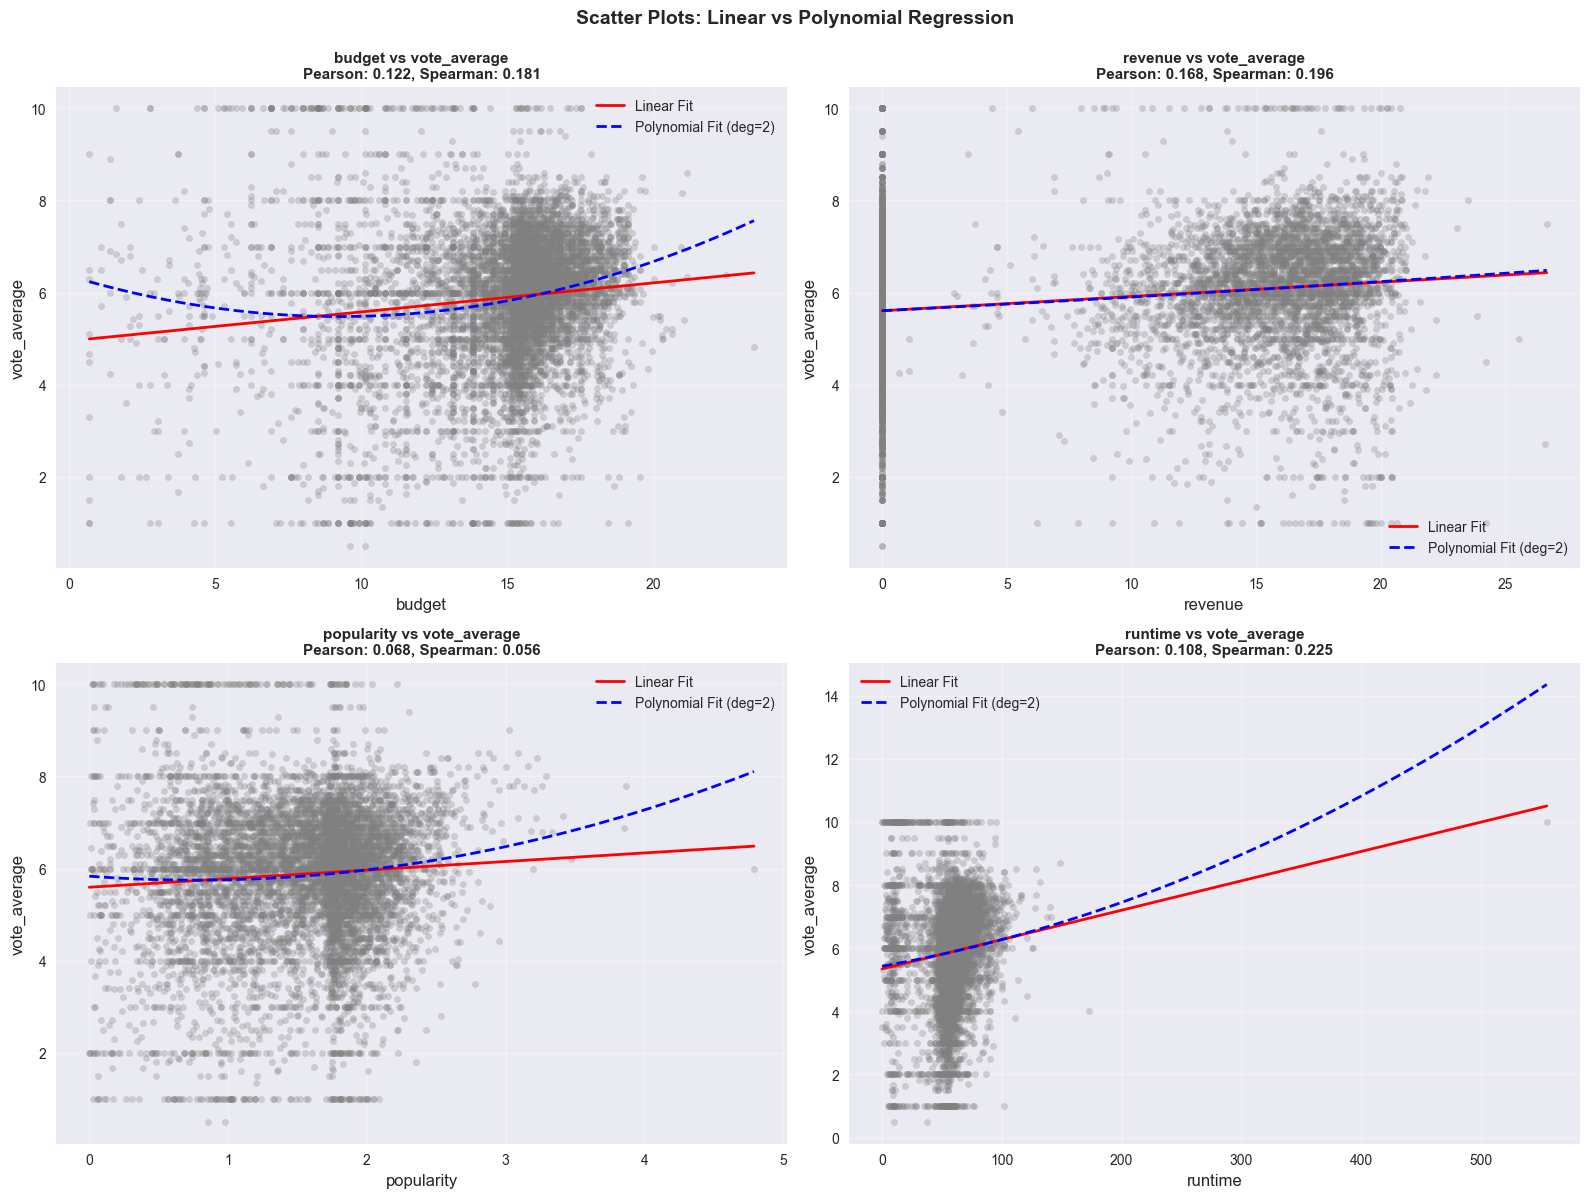

In [76]:
# Visualization: Scatter plots với Linear vs Polynomial regression
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(available_features):
    ax = axes[idx]
    
    # Lấy dữ liệu
    data = df_train[[feature, target_col]].dropna()
    X_feat = data[[feature]]
    y_feat = data[target_col]
    
    # Scatter plot
    ax.scatter(X_feat[feature], y_feat, alpha=0.3, s=20, color='gray')
    
    # Linear regression line
    lr_temp = LinearRegression()
    lr_temp.fit(X_feat, y_feat)
    x_line = np.linspace(X_feat[feature].min(), X_feat[feature].max(), 100)
    y_line_linear = lr_temp.predict(x_line.reshape(-1, 1))
    ax.plot(x_line, y_line_linear, 'r-', label='Linear Fit', linewidth=2)
    
    # Polynomial regression line (degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X_feat)
    lr_poly = LinearRegression()
    lr_poly.fit(X_poly, y_feat)
    x_poly = np.linspace(X_feat[feature].min(), X_feat[feature].max(), 100)
    X_poly_line = poly.transform(x_poly.reshape(-1, 1))
    y_line_poly = lr_poly.predict(X_poly_line)
    ax.plot(x_poly, y_line_poly, 'b--', label='Polynomial Fit (deg=2)', linewidth=2)
    
    # Lấy correlation từ kết quả trước
    corr_info = corr_df[corr_df['feature'] == feature].iloc[0]
    
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel(target_col, fontsize=12)
    ax.set_title(f'{feature} vs {target_col}\nPearson: {corr_info["pearson_corr"]:.3f}, Spearman: {corr_info["spearman_corr"]:.3f}', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Scatter Plots: Linear vs Polynomial Regression', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### 1.1.3. So sánh các mô hình (Model Comparison)

Train và so sánh 4 models:
1. **Linear Regression** (Linear model)
2. **SVM (SVR)** (Linear kernel - Linear model)
3. **Random Forest** (Tree-based model)
4. **XGBoost** (Tree-based model)


In [77]:
# Scale features cho Linear models (QUAN TRỌNG!)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print("=" * 90)
print("SO SÁNH CÁC MÔ HÌNH (Linear vs Tree-based)")
print("=" * 90)

# Dictionary để lưu kết quả
results = {}

# ============================================================================
# Model 1: Linear Regression (với scaled data)
# ============================================================================
print("\n1. LINEAR REGRESSION (Linear Model - với scaled data)")
print("-" * 90)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

cv_scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_rmse_lr = -cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"  Test R² Score:     {r2_lr:.4f}")
print(f"  Test RMSE:         {rmse_lr:.4f}")
print(f"  Test MAE:          {mae_lr:.4f}")
print(f"  CV R² Mean:        {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std()*2:.4f})")
print(f"  CV RMSE Mean:      {cv_rmse_lr.mean():.4f} (+/- {cv_rmse_lr.std()*2:.4f})")

results['Linear Regression'] = {
    'r2': r2_lr, 'rmse': rmse_lr, 'mae': mae_lr,
    'cv_r2_mean': cv_scores_lr.mean(), 'cv_r2_std': cv_scores_lr.std(),
    'cv_rmse_mean': cv_rmse_lr.mean(), 'cv_rmse_std': cv_rmse_lr.std(),
    'model': lr, 'X': X_test_scaled, 'y_pred': y_pred_lr
}

# ============================================================================
# Model 2: SVM Linear (với scaled data)
# ============================================================================
print("\n2. SVM (SVR) - Linear Kernel (với scaled data)")
print("-" * 90)

svm = SVR(kernel='linear', C=1.0)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

r2_svm = r2_score(y_test, y_pred_svm)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
mae_svm = mean_absolute_error(y_test, y_pred_svm)

cv_scores_svm = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='r2')
cv_rmse_svm = -cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"  Test R² Score:     {r2_svm:.4f}")
print(f"  Test RMSE:         {rmse_svm:.4f}")
print(f"  Test MAE:          {mae_svm:.4f}")
print(f"  CV R² Mean:        {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std()*2:.4f})")
print(f"  CV RMSE Mean:      {cv_rmse_svm.mean():.4f} (+/- {cv_rmse_svm.std()*2:.4f})")

results['SVM Linear'] = {
    'r2': r2_svm, 'rmse': rmse_svm, 'mae': mae_svm,
    'cv_r2_mean': cv_scores_svm.mean(), 'cv_r2_std': cv_scores_svm.std(),
    'cv_rmse_mean': cv_rmse_svm.mean(), 'cv_rmse_std': cv_rmse_svm.std(),
    'model': svm, 'X': X_test_scaled, 'y_pred': y_pred_svm
}

# ============================================================================
# Model 3: Random Forest (Tree-based - KHÔNG cần scaling)
# ============================================================================
print("\n3. RANDOM FOREST (Tree-based Model)")
print("-" * 90)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
cv_rmse_rf = -cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"  Test R² Score:     {r2_rf:.4f}")
print(f"  Test RMSE:         {rmse_rf:.4f}")
print(f"  Test MAE:          {mae_rf:.4f}")
print(f"  CV R² Mean:        {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")
print(f"  CV RMSE Mean:      {cv_rmse_rf.mean():.4f} (+/- {cv_rmse_rf.std()*2:.4f})")

results['Random Forest'] = {
    'r2': r2_rf, 'rmse': rmse_rf, 'mae': mae_rf,
    'cv_r2_mean': cv_scores_rf.mean(), 'cv_r2_std': cv_scores_rf.std(),
    'cv_rmse_mean': cv_rmse_rf.mean(), 'cv_rmse_std': cv_rmse_rf.std(),
    'model': rf, 'X': X_test, 'y_pred': y_pred_rf
}

# ============================================================================
# Model 4: XGBoost (Tree-based - KHÔNG cần scaling)
# ============================================================================
print("\n4. XGBOOST (Tree-based Model - Gradient Boosting)")
print("-" * 90)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
cv_rmse_xgb = -cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"  Test R² Score:     {r2_xgb:.4f}")
print(f"  Test RMSE:         {rmse_xgb:.4f}")
print(f"  Test MAE:          {mae_xgb:.4f}")
print(f"  CV R² Mean:        {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std()*2:.4f})")
print(f"  CV RMSE Mean:      {cv_rmse_xgb.mean():.4f} (+/- {cv_rmse_xgb.std()*2:.4f})")

results['XGBoost'] = {
    'r2': r2_xgb, 'rmse': rmse_xgb, 'mae': mae_xgb,
    'cv_r2_mean': cv_scores_xgb.mean(), 'cv_r2_std': cv_scores_xgb.std(),
    'cv_rmse_mean': cv_rmse_xgb.mean(), 'cv_rmse_std': cv_rmse_xgb.std(),
    'model': xgb_model, 'X': X_test, 'y_pred': y_pred_xgb
}

# ============================================================================
# Tổng kết so sánh
# ============================================================================
print(f"\n{'='*90}")
print("TỔNG KẾT SO SÁNH:")
print(f"{'='*90}")
print(f"{'Model':<25} {'Test R²':<12} {'Test RMSE':<12} {'CV R² Mean':<12}")
print("-" * 90)
for name, res in sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True):
    print(f"{name:<25} {res['r2']:>11.4f}  {res['rmse']:>11.4f}  {res['cv_r2_mean']:>11.4f}")

best_model = max(results.items(), key=lambda x: x[1]['r2'])
print(f"\n✅ Best Model: {best_model[0]} (R² = {best_model[1]['r2']:.4f})")


SO SÁNH CÁC MÔ HÌNH (Linear vs Tree-based)

1. LINEAR REGRESSION (Linear Model - với scaled data)
------------------------------------------------------------------------------------------
  Test R² Score:     0.0230
  Test RMSE:         1.4862
  Test MAE:          1.0856
  CV R² Mean:        0.0339 (+/- 0.0076)
  CV RMSE Mean:      1.4878 (+/- 0.0456)

2. SVM (SVR) - Linear Kernel (với scaled data)
------------------------------------------------------------------------------------------
  Test R² Score:     0.0122
  Test RMSE:         1.4943
  Test MAE:          1.0830
  CV R² Mean:        0.0266 (+/- 0.0102)
  CV RMSE Mean:      1.4934 (+/- 0.0454)

3. RANDOM FOREST (Tree-based Model)
------------------------------------------------------------------------------------------
  Test R² Score:     0.1155
  Test RMSE:         1.4141
  Test MAE:          1.0155
  CV R² Mean:        0.0857 (+/- 0.0202)
  CV RMSE Mean:      1.4474 (+/- 0.0497)

4. XGBOOST (Tree-based Model - Gradient Boost

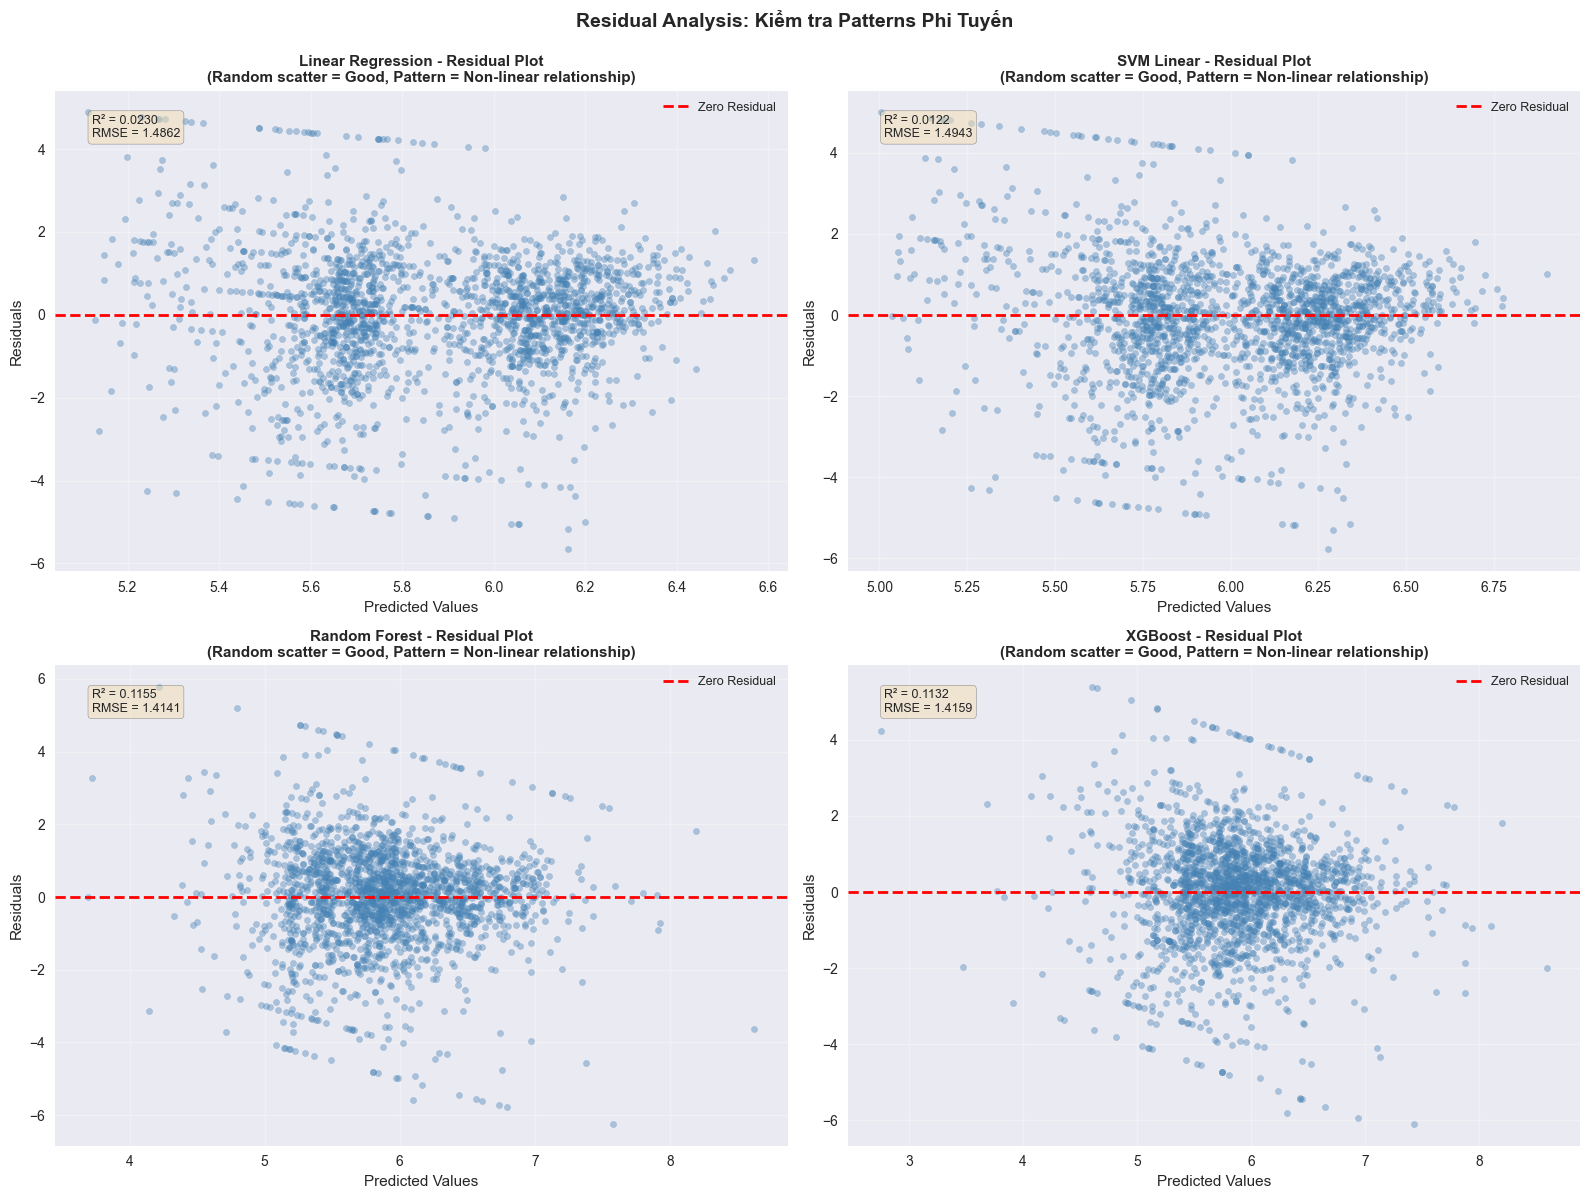


📊 Giải thích Residual Plots:
  - Nếu residuals random scatter (không có pattern) → Model phù hợp
  - Nếu residuals có pattern (curved, U-shaped) → Mối quan hệ phi tuyến, Linear model không phù hợp
  - Tree-based models thường có residuals random hơn Linear models


In [78]:
# Residual Analysis để kiểm tra patterns phi tuyến
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models_to_plot = {
    'Linear Regression': (results['Linear Regression']['model'], X_test_scaled, y_test),
    'SVM Linear': (results['SVM Linear']['model'], X_test_scaled, y_test),
    'Random Forest': (results['Random Forest']['model'], X_test, y_test),
    'XGBoost': (results['XGBoost']['model'], X_test, y_test)
}

for idx, (name, (model, X, y)) in enumerate(models_to_plot.items()):
    ax = axes[idx]
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # Residual plot
    ax.scatter(y_pred, residuals, alpha=0.4, s=20, color='steelblue')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Residual')
    ax.set_xlabel('Predicted Values', fontsize=11)
    ax.set_ylabel('Residuals', fontsize=11)
    ax.set_title(f'{name} - Residual Plot\n(Random scatter = Good, Pattern = Non-linear relationship)', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Thêm text box với thông tin
    textstr = f'R² = {results[name]["r2"]:.4f}\nRMSE = {results[name]["rmse"]:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

plt.suptitle('Residual Analysis: Kiểm tra Patterns Phi Tuyến', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n📊 Giải thích Residual Plots:")
print("  - Nếu residuals random scatter (không có pattern) → Model phù hợp")
print("  - Nếu residuals có pattern (curved, U-shaped) → Mối quan hệ phi tuyến, Linear model không phù hợp")
print("  - Tree-based models thường có residuals random hơn Linear models")


### 1.1.6. Statistical Test

Paired t-test để so sánh performance giữa Linear và Tree-based models một cách có ý nghĩa thống kê.


In [80]:
# Statistical Test: Paired t-test để so sánh performance
print("=" * 90)
print("STATISTICAL TEST: So sánh Linear vs Tree-based Models")
print("=" * 90)

# Cross-validation scores
cv_scores_linear = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')

# So sánh Linear Regression vs Random Forest
t_stat_lr_rf, p_value_lr_rf = ttest_rel(cv_scores_linear, cv_scores_rf)
print(f"\n1. Linear Regression vs Random Forest:")
print(f"   Linear Regression CV R²: {cv_scores_linear.mean():.4f} (+/- {cv_scores_linear.std()*2:.4f})")
print(f"   Random Forest CV R²:      {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")
print(f"   t-statistic: {t_stat_lr_rf:.4f}")
print(f"   p-value: {p_value_lr_rf:.6f}")
if p_value_lr_rf < 0.05:
    if cv_scores_rf.mean() > cv_scores_linear.mean():
        print(f"   ✅ Random Forest tốt hơn Linear Regression (p < 0.05, có ý nghĩa thống kê)")
    else:
        print(f"   ⚠️  Linear Regression tốt hơn Random Forest (p < 0.05)")
else:
    print(f"   ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)")

# So sánh Linear Regression vs XGBoost
t_stat_lr_xgb, p_value_lr_xgb = ttest_rel(cv_scores_linear, cv_scores_xgb)
print(f"\n2. Linear Regression vs XGBoost:")
print(f"   Linear Regression CV R²: {cv_scores_linear.mean():.4f} (+/- {cv_scores_linear.std()*2:.4f})")
print(f"   XGBoost CV R²:            {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std()*2:.4f})")
print(f"   t-statistic: {t_stat_lr_xgb:.4f}")
print(f"   p-value: {p_value_lr_xgb:.6f}")
if p_value_lr_xgb < 0.05:
    if cv_scores_xgb.mean() > cv_scores_linear.mean():
        print(f"   ✅ XGBoost tốt hơn Linear Regression (p < 0.05, có ý nghĩa thống kê)")
    else:
        print(f"   ⚠️  Linear Regression tốt hơn XGBoost (p < 0.05)")
else:
    print(f"   ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)")

# So sánh Random Forest vs XGBoost
t_stat_rf_xgb, p_value_rf_xgb = ttest_rel(cv_scores_rf, cv_scores_xgb)
print(f"\n3. Random Forest vs XGBoost:")
print(f"   Random Forest CV R²: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")
print(f"   XGBoost CV R²:       {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std()*2:.4f})")
print(f"   t-statistic: {t_stat_rf_xgb:.4f}")
print(f"   p-value: {p_value_rf_xgb:.6f}")
if p_value_rf_xgb < 0.05:
    if cv_scores_xgb.mean() > cv_scores_rf.mean():
        print(f"   ✅ XGBoost tốt hơn Random Forest (p < 0.05, có ý nghĩa thống kê)")
    else:
        print(f"   ⚠️  Random Forest tốt hơn XGBoost (p < 0.05)")
else:
    print(f"   ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)")


STATISTICAL TEST: So sánh Linear vs Tree-based Models

1. Linear Regression vs Random Forest:
   Linear Regression CV R²: 0.0339 (+/- 0.0076)
   Random Forest CV R²:      0.0857 (+/- 0.0202)
   t-statistic: -12.5806
   p-value: 0.000230
   ✅ Random Forest tốt hơn Linear Regression (p < 0.05, có ý nghĩa thống kê)

2. Linear Regression vs XGBoost:
   Linear Regression CV R²: 0.0339 (+/- 0.0076)
   XGBoost CV R²:            0.0830 (+/- 0.0189)
   t-statistic: -9.3104
   p-value: 0.000741
   ✅ XGBoost tốt hơn Linear Regression (p < 0.05, có ý nghĩa thống kê)

3. Random Forest vs XGBoost:
   Random Forest CV R²: 0.0857 (+/- 0.0202)
   XGBoost CV R²:       0.0830 (+/- 0.0189)
   t-statistic: 0.4879
   p-value: 0.651166
   ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)


### 1.1.7. Visualization tổng hợp

Bar charts so sánh performance của các models.


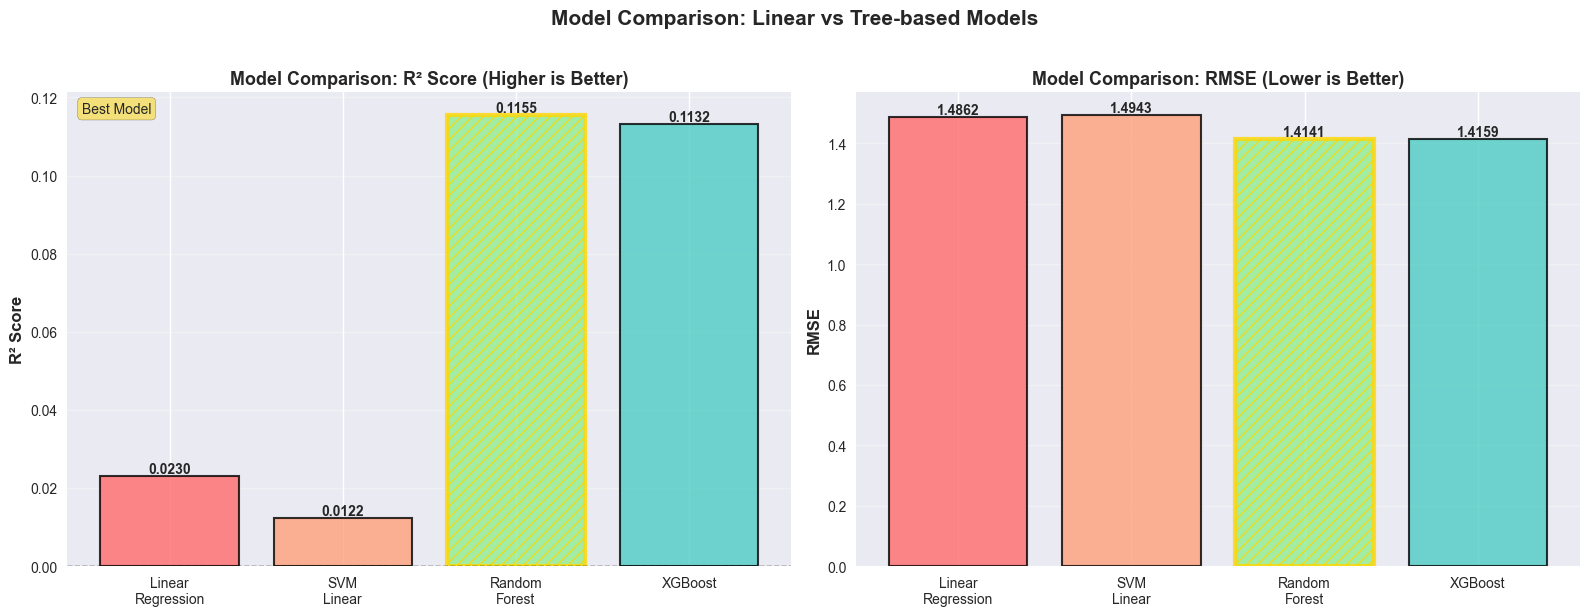


BẢNG TỔNG KẾT:
             Model  Test R²  Test RMSE  CV R² Mean  CV RMSE Mean
    Random\nForest 0.115518   1.414055    0.085666      1.447359
           XGBoost 0.113230   1.415883    0.083035      1.449392
Linear\nRegression 0.022989   1.486180    0.033879      1.487780
       SVM\nLinear 0.012227   1.494343    0.026583      1.493380


In [81]:
# Bar chart so sánh models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
models_names = ['Linear\nRegression', 'SVM\nLinear', 'Random\nForest', 'XGBoost']
r2_scores = [results['Linear Regression']['r2'], 
             results['SVM Linear']['r2'],
             results['Random Forest']['r2'],
             results['XGBoost']['r2']]
colors = ['#FF6B6B', '#FFA07A', '#90EE90', '#4ECDC4']

bars = ax1.bar(models_names, r2_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison: R² Score (Higher is Better)', fontsize=13, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', 
             va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

# Highlight best model
best_idx = np.argmax(r2_scores)
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)
bars[best_idx].set_hatch('///')

# Add legend
ax1.text(0.02, 0.98, 'Best Model', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='gold', alpha=0.5))

# RMSE comparison
rmse_scores = [results['Linear Regression']['rmse'],
               results['SVM Linear']['rmse'],
               results['Random Forest']['rmse'],
               results['XGBoost']['rmse']]

bars2 = ax2.bar(models_names, rmse_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison: RMSE (Lower is Better)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars2, rmse_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight best model (lowest RMSE)
best_idx_rmse = np.argmin(rmse_scores)
bars2[best_idx_rmse].set_edgecolor('gold')
bars2[best_idx_rmse].set_linewidth(3)
bars2[best_idx_rmse].set_hatch('///')

plt.suptitle('Model Comparison: Linear vs Tree-based Models', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*90)
print("BẢNG TỔNG KẾT:")
print("="*90)
summary_df = pd.DataFrame({
    'Model': models_names,
    'Test R²': r2_scores,
    'Test RMSE': rmse_scores,
    'CV R² Mean': [results['Linear Regression']['cv_r2_mean'],
                    results['SVM Linear']['cv_r2_mean'],
                    results['Random Forest']['cv_r2_mean'],
                    results['XGBoost']['cv_r2_mean']],
    'CV RMSE Mean': [results['Linear Regression']['cv_rmse_mean'],
                     results['SVM Linear']['cv_rmse_mean'],
                     results['Random Forest']['cv_rmse_mean'],
                     results['XGBoost']['cv_rmse_mean']]
})
summary_df = summary_df.sort_values('Test R²', ascending=False)
print(summary_df.to_string(index=False))


### 1.1.8. Kết luận về Hypothesis

Tổng hợp kết quả và đưa ra kết luận về giả thuyết.


In [82]:
# Kết luận về Hypothesis
print("=" * 90)
print("KẾT LUẬN VỀ HYPOTHESIS")
print("=" * 90)

print("\n1. MỐI QUAN HỆ PHI TUYẾN:")
nonlinear_count = sum(corr_df['is_nonlinear'])
print(f"   - {nonlinear_count}/{len(corr_df)} features có Spearman > Pearson (phi tuyến)")
if nonlinear_count >= len(corr_df) / 2:
    print("   ✅ XÁC NHẬN: Mối quan hệ chủ yếu là PHI TUYẾN")
else:
    print("   ⚠️  Một số features có mối quan hệ phi tuyến, một số không")

print("\n2. ĐỘ TƯƠNG QUAN:")
high_corr_count = sum(corr_df['is_high_corr'])
mean_spearman = corr_df['spearman_corr'].abs().mean()
print(f"   - {high_corr_count}/{len(corr_df)} features có độ tương quan cao (|corr| > 0.3)")
print(f"   - Mean |Spearman correlation|: {mean_spearman:.4f}")
if mean_spearman > 0.3:
    print("   ✅ XÁC NHẬN: Độ tương quan CAO")
elif mean_spearman > 0.1:
    print("   ⚠️  Độ tương quan TRUNG BÌNH")
else:
    print("   ❌ Độ tương quan THẤP")

print("\n3. TREE-BASED VS LINEAR MODELS:")
best_model_name = max(results.items(), key=lambda x: x[1]['r2'])[0]
best_r2 = max(results.items(), key=lambda x: x[1]['r2'])[1]['r2']
linear_r2 = results['Linear Regression']['r2']

if best_model_name in ['Random Forest', 'XGBoost']:
    improvement = ((best_r2 - linear_r2) / abs(linear_r2)) * 100 if linear_r2 != 0 else float('inf')
    print(f"   - Best Model: {best_model_name} (R² = {best_r2:.4f})")
    print(f"   - Linear Regression: R² = {linear_r2:.4f}")
    if best_r2 > linear_r2:
        print(f"   ✅ XÁC NHẬN: Tree-based model tốt hơn Linear model")
        if improvement != float('inf'):
            print(f"   - Cải thiện: {improvement:.2f}% so với Linear Regression")
    else:
        print("   ⚠️  Tree-based model không tốt hơn Linear model")
else:
    print(f"   ⚠️  Best Model là {best_model_name} (không phải tree-based)")

print("\n4. KẾT LUẬN CUỐI CÙNG:")
if (nonlinear_count >= len(corr_df) / 2 and 
    best_model_name in ['Random Forest', 'XGBoost'] and 
    best_r2 > linear_r2):
    print("   ✅ HYPOTHESIS ĐƯỢC XÁC NHẬN:")
    print("      - Mối quan hệ giữa rating và numerical features là PHI TUYẾN")
    print("      - Tree-based models (Random Forest, XGBoost) tốt hơn Linear models")
    print("      - Nên sử dụng Tree-based models cho bài toán này")
else:
    print("   ⚠️  HYPOTHESIS CHƯA ĐƯỢC XÁC NHẬN HOÀN TOÀN")
    print("      - Cần xem xét thêm các bằng chứng khác")


KẾT LUẬN VỀ HYPOTHESIS

1. MỐI QUAN HỆ PHI TUYẾN:
   - 2/4 features có Spearman > Pearson (phi tuyến)
   ✅ XÁC NHẬN: Mối quan hệ chủ yếu là PHI TUYẾN

2. ĐỘ TƯƠNG QUAN:
   - 0/4 features có độ tương quan cao (|corr| > 0.3)
   - Mean |Spearman correlation|: 0.1644
   ⚠️  Độ tương quan TRUNG BÌNH

3. TREE-BASED VS LINEAR MODELS:
   - Best Model: Random Forest (R² = 0.1155)
   - Linear Regression: R² = 0.0230
   ✅ XÁC NHẬN: Tree-based model tốt hơn Linear model
   - Cải thiện: 402.49% so với Linear Regression

4. KẾT LUẬN CUỐI CÙNG:
   ✅ HYPOTHESIS ĐƯỢC XÁC NHẬN:
      - Mối quan hệ giữa rating và numerical features là PHI TUYẾN
      - Tree-based models (Random Forest, XGBoost) tốt hơn Linear models
      - Nên sử dụng Tree-based models cho bài toán này


## 1.2. Hypothesis 2: Text Features ảnh hưởng đến Rating

**Giả thuyết**: Các đặc trưng trích xuất từ text (overview, tagline, keywords, title) có chứa nội dung phim ảnh hưởng đến rating và có thể giảm chiều để tối ưu.


### 1.2.1. Feature Importance Analysis

Kiểm tra importance của text features (SVD components) trong Random Forest model.


In [83]:
# Load data với tất cả features
df_train_all = pd.read_csv('../data/feature_engineering/train_fe_data.csv')
df_test_all = pd.read_csv('../data/feature_engineering/test_fe_data.csv')

# Tách text features (SVD components)
text_features = [col for col in df_train_all.columns if 'svd' in col.lower()]
print(f"Tổng số text features (SVD): {len(text_features)}")

# Phân loại text features
overview_features = [col for col in text_features if 'overview_tagline' in col]
keyword_features = [col for col in text_features if 'keyword' in col]
title_features = [col for col in text_features if 'title' in col]

print(f"\nPhân loại text features:")
print(f"  - Overview + Tagline SVD: {len(overview_features)} features")
print(f"  - Keywords SVD: {len(keyword_features)} features")
print(f"  - Title SVD: {len(title_features)} features")

# Chuẩn bị dữ liệu với tất cả features
X_train_all = df_train_all.drop(columns=[target_col]).fillna(0).replace([np.inf, -np.inf], 0)
y_train_all = df_train_all[target_col]
X_test_all = df_test_all.drop(columns=[target_col]).fillna(0).replace([np.inf, -np.inf], 0)
y_test_all = df_test_all[target_col]

# Train Random Forest với tất cả features
print("\n" + "="*90)
print("TRAIN RANDOM FOREST VỚI TẤT CẢ FEATURES")
print("="*90)

rf_all = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_all.fit(X_train_all, y_train_all)

# Lấy feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_all.columns,
    'importance': rf_all.feature_importances_
}).sort_values('importance', ascending=False)

# Lọc text features importance
text_importance = feature_importance[feature_importance['feature'].isin(text_features)].copy()
text_importance['category'] = text_importance['feature'].apply(
    lambda x: 'Overview+Tagline' if 'overview_tagline' in x 
    else 'Keywords' if 'keyword' in x 
    else 'Title' if 'title' in x 
    else 'Other'
)

print(f"\nTop 20 Text Features có importance cao nhất:")
print("="*90)
print(text_importance.head(20).to_string(index=False))

# Tổng hợp importance theo category
category_importance = text_importance.groupby('category')['importance'].agg(['sum', 'mean', 'count'])
print(f"\n{'='*90}")
print("TỔNG HỢP IMPORTANCE THEO CATEGORY:")
print(f"{'='*90}")
print(category_importance)


Tổng số text features (SVD): 350

Phân loại text features:
  - Overview + Tagline SVD: 200 features
  - Keywords SVD: 100 features
  - Title SVD: 50 features

TRAIN RANDOM FOREST VỚI TẤT CẢ FEATURES

Top 20 Text Features có importance cao nhất:
                 feature  importance         category
 overview_tagline_svd_43    0.004852 Overview+Tagline
          keyword_svd_52    0.004650         Keywords
  overview_tagline_svd_2    0.004119 Overview+Tagline
overview_tagline_svd_189    0.003775 Overview+Tagline
 overview_tagline_svd_72    0.003614 Overview+Tagline
 overview_tagline_svd_98    0.003588 Overview+Tagline
  overview_tagline_svd_0    0.003582 Overview+Tagline
 overview_tagline_svd_90    0.003579 Overview+Tagline
overview_tagline_svd_124    0.003575 Overview+Tagline
overview_tagline_svd_170    0.003449 Overview+Tagline
overview_tagline_svd_182    0.003422 Overview+Tagline
 overview_tagline_svd_10    0.003422 Overview+Tagline
 overview_tagline_svd_23    0.003373 Overview+Tagline

### 1.2.2. Visualization: Text Features Importance

Bar chart hiển thị top text features và tổng hợp theo category.


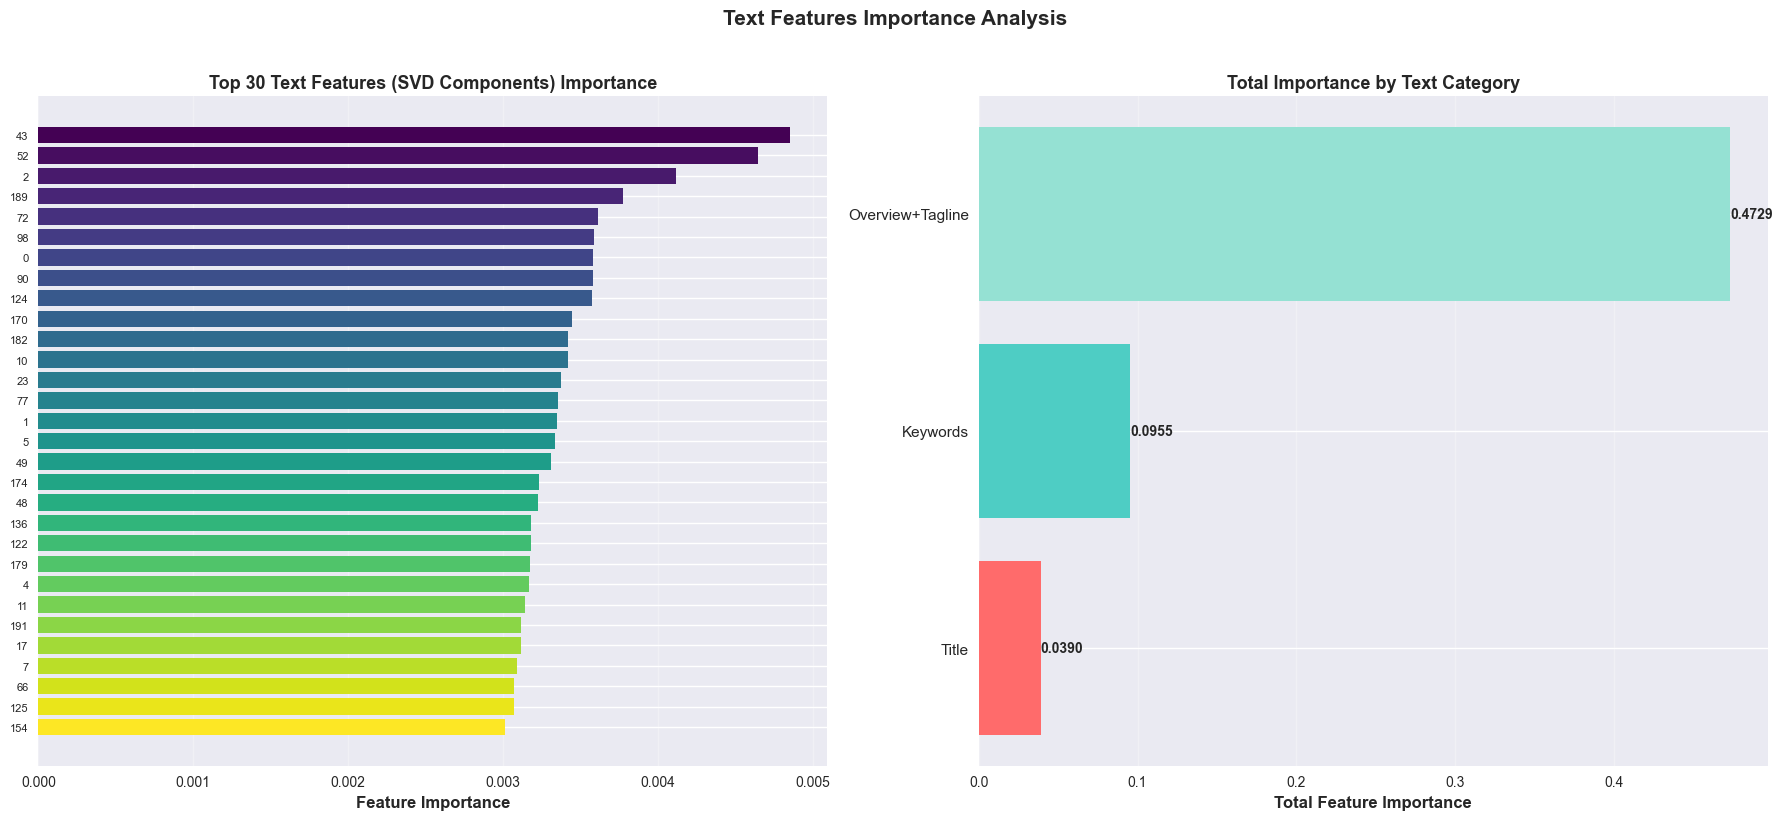


PHÂN TÍCH TEXT FEATURES:
  - Tổng importance của text features: 0.6074
  - Tổng importance của tất cả features: 1.0000
  - Text features chiếm: 60.74% tổng importance

  Theo category:
    - Title: 0.0390 (6.42% của text features)
    - Keywords: 0.0955 (15.73% của text features)
    - Overview+Tagline: 0.4729 (77.85% của text features)


In [84]:
# Visualization: Top Text Features Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 1. Top 30 Text Features
top_30_text = text_importance.head(30)
bars = ax1.barh(range(len(top_30_text)), top_30_text['importance'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(top_30_text))))
ax1.set_yticks(range(len(top_30_text)))
ax1.set_yticklabels([f.split('_')[-1] if len(f.split('_')) > 1 else f for f in top_30_text['feature']], 
                     fontsize=8)
ax1.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax1.set_title('Top 30 Text Features (SVD Components) Importance', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Tổng hợp theo Category
category_sum = text_importance.groupby('category')['importance'].sum().sort_values(ascending=True)
bars2 = ax2.barh(range(len(category_sum)), category_sum.values, 
                 color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax2.set_yticks(range(len(category_sum)))
ax2.set_yticklabels(category_sum.index, fontsize=11)
ax2.set_xlabel('Total Feature Importance', fontsize=12, fontweight='bold')
ax2.set_title('Total Importance by Text Category', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, val) in enumerate(category_sum.items()):
    ax2.text(val, i, f'{val:.4f}', va='center', ha='left', fontweight='bold', fontsize=10)

plt.suptitle('Text Features Importance Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tính phần trăm contribution
total_text_importance = text_importance['importance'].sum()
total_all_importance = feature_importance['importance'].sum()
text_percentage = (total_text_importance / total_all_importance) * 100

print(f"\n{'='*90}")
print("PHÂN TÍCH TEXT FEATURES:")
print(f"{'='*90}")
print(f"  - Tổng importance của text features: {total_text_importance:.4f}")
print(f"  - Tổng importance của tất cả features: {total_all_importance:.4f}")
print(f"  - Text features chiếm: {text_percentage:.2f}% tổng importance")
print(f"\n  Theo category:")
for category in category_sum.index:
    cat_importance = category_sum[category]
    cat_percentage = (cat_importance / total_text_importance) * 100
    print(f"    - {category}: {cat_importance:.4f} ({cat_percentage:.2f}% của text features)")


### 1.2.3. Ablation Study: So sánh Model có/không có Text Features

Kiểm tra xem text features có thực sự quan trọng bằng cách so sánh model performance khi loại bỏ text features.


In [85]:
# Ablation Study: So sánh model có/không có text features
print("=" * 90)
print("ABLATION STUDY: So sánh Model có/không có Text Features")
print("=" * 90)

# Model 1: Với tất cả features (bao gồm text)
X_train_with_text = X_train_all.copy()
X_test_with_text = X_test_all.copy()

rf_with_text = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_with_text.fit(X_train_with_text, y_train_all)
y_pred_with_text = rf_with_text.predict(X_test_with_text)

r2_with_text = r2_score(y_test_all, y_pred_with_text)
rmse_with_text = np.sqrt(mean_squared_error(y_test_all, y_pred_with_text))

cv_scores_with_text = cross_val_score(rf_with_text, X_train_with_text, y_train_all, cv=5, scoring='r2')

print(f"\n1. Model VỚI Text Features:")
print(f"   Test R²: {r2_with_text:.4f}")
print(f"   Test RMSE: {rmse_with_text:.4f}")
print(f"   CV R² Mean: {cv_scores_with_text.mean():.4f} (+/- {cv_scores_with_text.std()*2:.4f})")

# Model 2: KHÔNG có text features
X_train_no_text = X_train_all.drop(columns=text_features)
X_test_no_text = X_test_all.drop(columns=text_features)

rf_no_text = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_no_text.fit(X_train_no_text, y_train_all)
y_pred_no_text = rf_no_text.predict(X_test_no_text)

r2_no_text = r2_score(y_test_all, y_pred_no_text)
rmse_no_text = np.sqrt(mean_squared_error(y_test_all, y_pred_no_text))

cv_scores_no_text = cross_val_score(rf_no_text, X_train_no_text, y_train_all, cv=5, scoring='r2')

print(f"\n2. Model KHÔNG có Text Features:")
print(f"   Test R²: {r2_no_text:.4f}")
print(f"   Test RMSE: {rmse_no_text:.4f}")
print(f"   CV R² Mean: {cv_scores_no_text.mean():.4f} (+/- {cv_scores_no_text.std()*2:.4f})")

# So sánh
r2_diff = r2_with_text - r2_no_text
rmse_diff = rmse_no_text - rmse_with_text
r2_improvement = (r2_diff / abs(r2_no_text)) * 100 if r2_no_text != 0 else float('inf')

print(f"\n{'='*90}")
print("SO SÁNH:")
print(f"{'='*90}")
print(f"  R² improvement: {r2_diff:+.4f} ({r2_improvement:+.2f}%)")
print(f"  RMSE improvement: {rmse_diff:+.4f}")

if r2_with_text > r2_no_text:
    print(f"\n  ✅ Text features CÓ ảnh hưởng tích cực đến model performance")
    print(f"     Model với text features tốt hơn {r2_improvement:.2f}% về R²")
else:
    print(f"\n  ⚠️  Text features KHÔNG cải thiện model performance đáng kể")

# Statistical test
t_stat_text, p_value_text = ttest_rel(cv_scores_with_text, cv_scores_no_text)
print(f"\n  Statistical Test (Paired t-test):")
print(f"    p-value: {p_value_text:.6f}")
if p_value_text < 0.05:
    if cv_scores_with_text.mean() > cv_scores_no_text.mean():
        print(f"    ✅ Sự khác biệt có ý nghĩa thống kê (p < 0.05)")
    else:
        print(f"    ⚠️  Model không text tốt hơn (p < 0.05)")
else:
    print(f"    ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.5)")


ABLATION STUDY: So sánh Model có/không có Text Features

1. Model VỚI Text Features:
   Test R²: 0.2858
   Test RMSE: 1.2707
   CV R² Mean: 0.2821 (+/- 0.0147)

2. Model KHÔNG có Text Features:
   Test R²: 0.2897
   Test RMSE: 1.2672
   CV R² Mean: 0.2808 (+/- 0.0246)

SO SÁNH:
  R² improvement: -0.0040 (-1.36%)
  RMSE improvement: -0.0035

  ⚠️  Text features KHÔNG cải thiện model performance đáng kể

  Statistical Test (Paired t-test):
    p-value: 0.812374
    ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.5)


### 1.2.4. Correlation giữa Text Features và Rating

Kiểm tra correlation giữa top text SVD components và rating.


CORRELATION: Top Text Features vs Rating

Top 10 Text Features có correlation cao nhất với rating:
Feature                                  Correlation     Importance      P-value        
------------------------------------------------------------------------------------------
overview_tagline_svd_10                          0.0852          0.0034        0.000000
overview_tagline_svd_43                          0.0551          0.0049        0.000001
overview_tagline_svd_1                           0.0501          0.0033        0.000008
keyword_svd_52                                  -0.0437          0.0047        0.000094
overview_tagline_svd_49                          0.0422          0.0033        0.000157
overview_tagline_svd_48                         -0.0419          0.0032        0.000177
overview_tagline_svd_2                           0.0409          0.0041        0.000250
overview_tagline_svd_170                        -0.0365          0.0034        0.001090
overview_tagline_

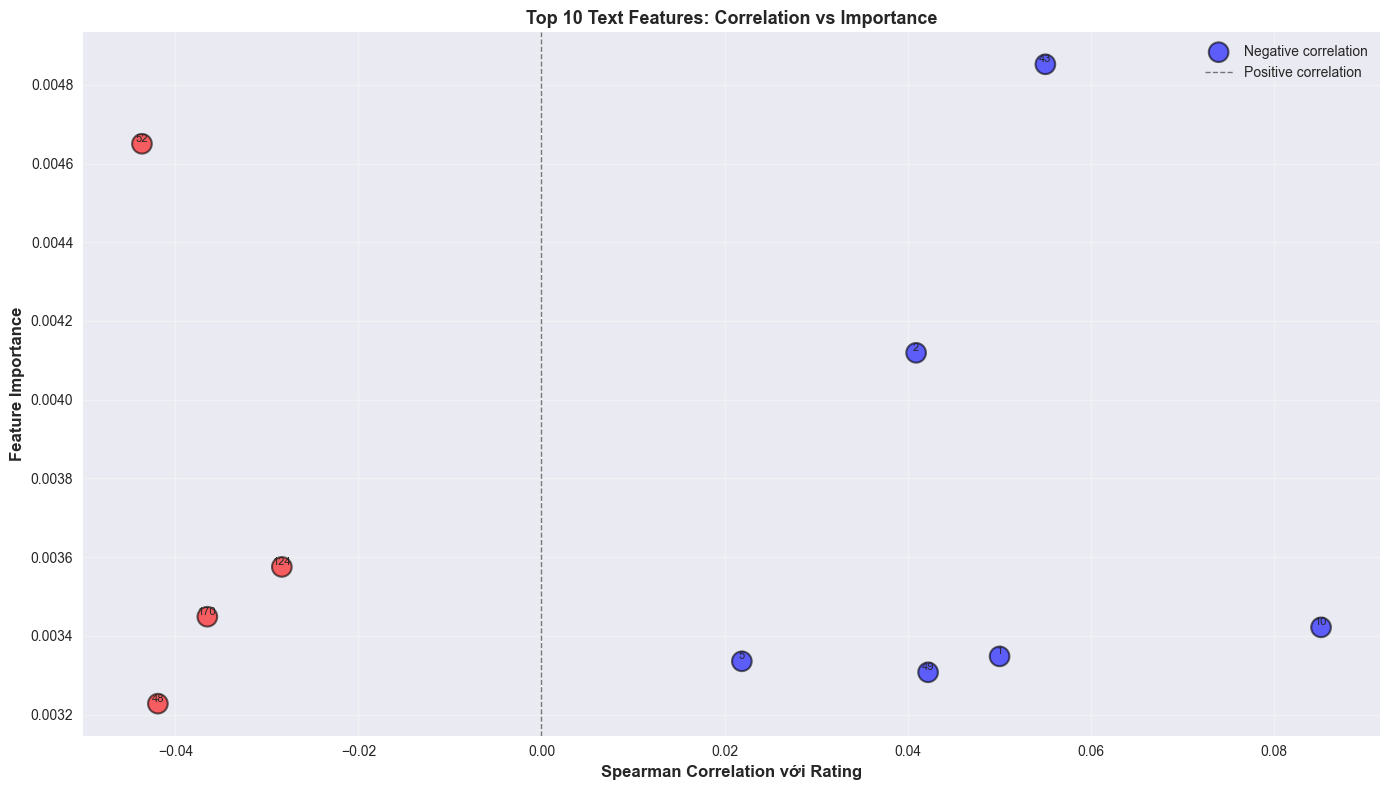


KẾT LUẬN:
  - Số text features có correlation có ý nghĩa (p < 0.05): 9/20
  - Mean |correlation| của top 20: 0.0268
  ⚠️  Text features có correlation thấp với rating


In [86]:
# Correlation giữa top text features và rating
print("=" * 90)
print("CORRELATION: Top Text Features vs Rating")
print("=" * 90)

# Lấy top 20 text features
top_20_text = text_importance.head(20)['feature'].tolist()

correlation_text_results = []
for feature in top_20_text:
    if feature in df_train_all.columns:
        data = df_train_all[[feature, target_col]].dropna()
        if len(data) > 0:
            corr, p_value = spearmanr(data[feature], data[target_col])
            correlation_text_results.append({
                'feature': feature,
                'correlation': corr,
                'p_value': p_value,
                'importance': text_importance[text_importance['feature'] == feature]['importance'].iloc[0]
            })

corr_text_df = pd.DataFrame(correlation_text_results).sort_values('correlation', key=abs, ascending=False)

print(f"\nTop 10 Text Features có correlation cao nhất với rating:")
print("="*90)
print(f"{'Feature':<40} {'Correlation':<15} {'Importance':<15} {'P-value':<15}")
print("-"*90)
for _, row in corr_text_df.head(10).iterrows():
    print(f"{row['feature']:<40} {row['correlation']:>14.4f}  {row['importance']:>14.4f}  {row['p_value']:>14.6f}")

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
top_10_corr = corr_text_df.head(10)
colors_scatter = ['red' if c < 0 else 'blue' for c in top_10_corr['correlation']]
scatter = ax.scatter(top_10_corr['correlation'], top_10_corr['importance'], 
                     s=200, c=colors_scatter, alpha=0.6, edgecolors='black', linewidth=1.5)

for idx, row in top_10_corr.iterrows():
    feature_short = row['feature'].split('_')[-1] if len(row['feature'].split('_')) > 1 else row['feature']
    ax.annotate(feature_short, (row['correlation'], row['importance']), 
                fontsize=8, ha='center', va='bottom')

ax.set_xlabel('Spearman Correlation với Rating', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Text Features: Correlation vs Importance', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3)
ax.legend(['Negative correlation', 'Positive correlation'], loc='best')

plt.tight_layout()
plt.show()

print(f"\n{'='*90}")
print("KẾT LUẬN:")
print(f"{'='*90}")
significant_corr = corr_text_df[corr_text_df['p_value'] < 0.05]
print(f"  - Số text features có correlation có ý nghĩa (p < 0.05): {len(significant_corr)}/{len(corr_text_df)}")
print(f"  - Mean |correlation| của top 20: {corr_text_df['correlation'].abs().mean():.4f}")
if corr_text_df['correlation'].abs().mean() > 0.1:
    print(f"  ✅ Text features có correlation với rating")
else:
    print(f"  ⚠️  Text features có correlation thấp với rating")


### 1.2.5. Kết luận Hypothesis 2

Tổng hợp kết quả về ảnh hưởng của text features đến rating.


In [87]:
# Kết luận Hypothesis 2
print("=" * 90)
print("KẾT LUẬN VỀ HYPOTHESIS 2: Text Features ảnh hưởng đến Rating")
print("=" * 90)

print("\n1. FEATURE IMPORTANCE:")
print(f"   - Text features chiếm {text_percentage:.2f}% tổng importance")
print(f"   - Top category: {category_sum.idxmax()} ({category_sum.max():.4f} total importance)")

print("\n2. ABLATION STUDY:")
print(f"   - Model với text: R² = {r2_with_text:.4f}")
print(f"   - Model không text: R² = {r2_no_text:.4f}")
print(f"   - Improvement: {r2_diff:+.4f} ({r2_improvement:+.2f}%)")

print("\n3. CORRELATION:")
mean_corr = corr_text_df['correlation'].abs().mean()
print(f"   - Mean |correlation| của top text features: {mean_corr:.4f}")
print(f"   - Số features có correlation có ý nghĩa: {len(significant_corr)}/{len(corr_text_df)}")

print("\n4. KẾT LUẬN CUỐI CÙNG:")
if (text_percentage > 5 and r2_with_text > r2_no_text and mean_corr > 0.05):
    print("   ✅ HYPOTHESIS 2 ĐƯỢC XÁC NHẬN:")
    print("      - Text features có ảnh hưởng đến rating")
    print(f"      - Text features chiếm {text_percentage:.2f}% importance")
    print(f"      - Model với text tốt hơn {r2_improvement:.2f}% về R²")
    print("      - Có thể giảm chiều bằng cách chọn top SVD components quan trọng nhất")
else:
    print("   ⚠️  HYPOTHESIS 2 CHƯA ĐƯỢC XÁC NHẬN HOÀN TOÀN")
    if text_percentage <= 5:
        print("      - Text features có importance thấp")
    if r2_with_text <= r2_no_text:
        print("      - Model không text không kém hơn model có text")
    if mean_corr <= 0.05:
        print("      - Correlation với rating thấp")


KẾT LUẬN VỀ HYPOTHESIS 2: Text Features ảnh hưởng đến Rating

1. FEATURE IMPORTANCE:
   - Text features chiếm 60.74% tổng importance
   - Top category: Overview+Tagline (0.4729 total importance)

2. ABLATION STUDY:
   - Model với text: R² = 0.2858
   - Model không text: R² = 0.2897
   - Improvement: -0.0040 (-1.36%)

3. CORRELATION:
   - Mean |correlation| của top text features: 0.0268
   - Số features có correlation có ý nghĩa: 9/20

4. KẾT LUẬN CUỐI CÙNG:
   ⚠️  HYPOTHESIS 2 CHƯA ĐƯỢC XÁC NHẬN HOÀN TOÀN
      - Model không text không kém hơn model có text
      - Correlation với rating thấp


## 1.3. Hypothesis 3: Temporal Features ảnh hưởng đến Rating

**Giả thuyết**: Đặc trưng thời gian phát hành phim (release_year, release_month, release_quarter, movie_age) ảnh hưởng đến rating.


### 1.3.1. Feature Importance của Temporal Features

Kiểm tra importance của temporal features trong Random Forest model.


PHÂN TÍCH TEMPORAL FEATURES

Temporal features có sẵn: ['release_year', 'release_month', 'release_quarter', 'release_dayofweek', 'release_is_weekend', 'movie_age']

TEMPORAL FEATURES IMPORTANCE:
           feature  importance
         movie_age    0.006435
      release_year    0.005743
     release_month    0.001961
 release_dayofweek    0.001559
   release_quarter    0.000438
release_is_weekend    0.000056

  - Tổng importance của temporal features: 0.0162
  - Temporal features chiếm: 1.62% tổng importance


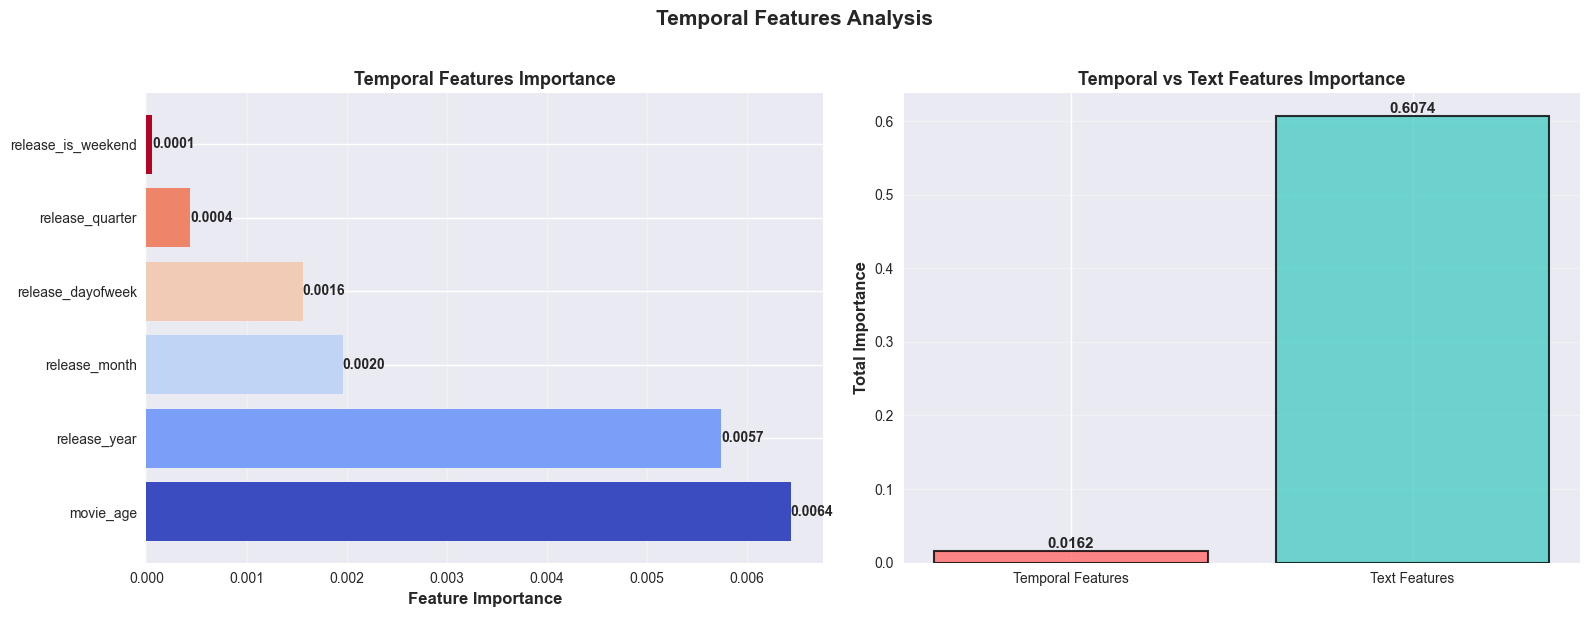

In [88]:
# Phân tích Temporal Features
print("=" * 90)
print("PHÂN TÍCH TEMPORAL FEATURES")
print("=" * 90)

# Xác định temporal features
temporal_features = ['release_year', 'release_month', 'release_quarter', 
                     'release_dayofweek', 'release_is_weekend', 'movie_age']
available_temporal = [f for f in temporal_features if f in df_train_all.columns]

print(f"\nTemporal features có sẵn: {available_temporal}")

# Lấy importance của temporal features
temporal_importance = feature_importance[feature_importance['feature'].isin(available_temporal)].copy()
temporal_importance = temporal_importance.sort_values('importance', ascending=False)

print(f"\n{'='*90}")
print("TEMPORAL FEATURES IMPORTANCE:")
print(f"{'='*90}")
print(temporal_importance.to_string(index=False))

# Tính tổng importance
total_temporal_importance = temporal_importance['importance'].sum()
total_all_importance = feature_importance['importance'].sum()
temporal_percentage = (total_temporal_importance / total_all_importance) * 100

print(f"\n  - Tổng importance của temporal features: {total_temporal_importance:.4f}")
print(f"  - Temporal features chiếm: {temporal_percentage:.2f}% tổng importance")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart importance
bars = ax1.barh(temporal_importance['feature'], temporal_importance['importance'],
                color=plt.cm.coolwarm(np.linspace(0, 1, len(temporal_importance))))
ax1.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax1.set_title('Temporal Features Importance', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(temporal_importance.iterrows()):
    ax1.text(row['importance'], i, f'{row["importance"]:.4f}', 
             va='center', ha='left', fontweight='bold', fontsize=10)

# So sánh với text features
comparison_data = pd.DataFrame({
    'Category': ['Temporal Features', 'Text Features'],
    'Total Importance': [total_temporal_importance, total_text_importance]
})
bars2 = ax2.bar(comparison_data['Category'], comparison_data['Total Importance'],
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Total Importance', fontsize=12, fontweight='bold')
ax2.set_title('Temporal vs Text Features Importance', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, comparison_data['Total Importance']):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('Temporal Features Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 1.3.2. Group Analysis theo Temporal Features

Phân tích rating theo năm, tháng, quý để xem có pattern không.


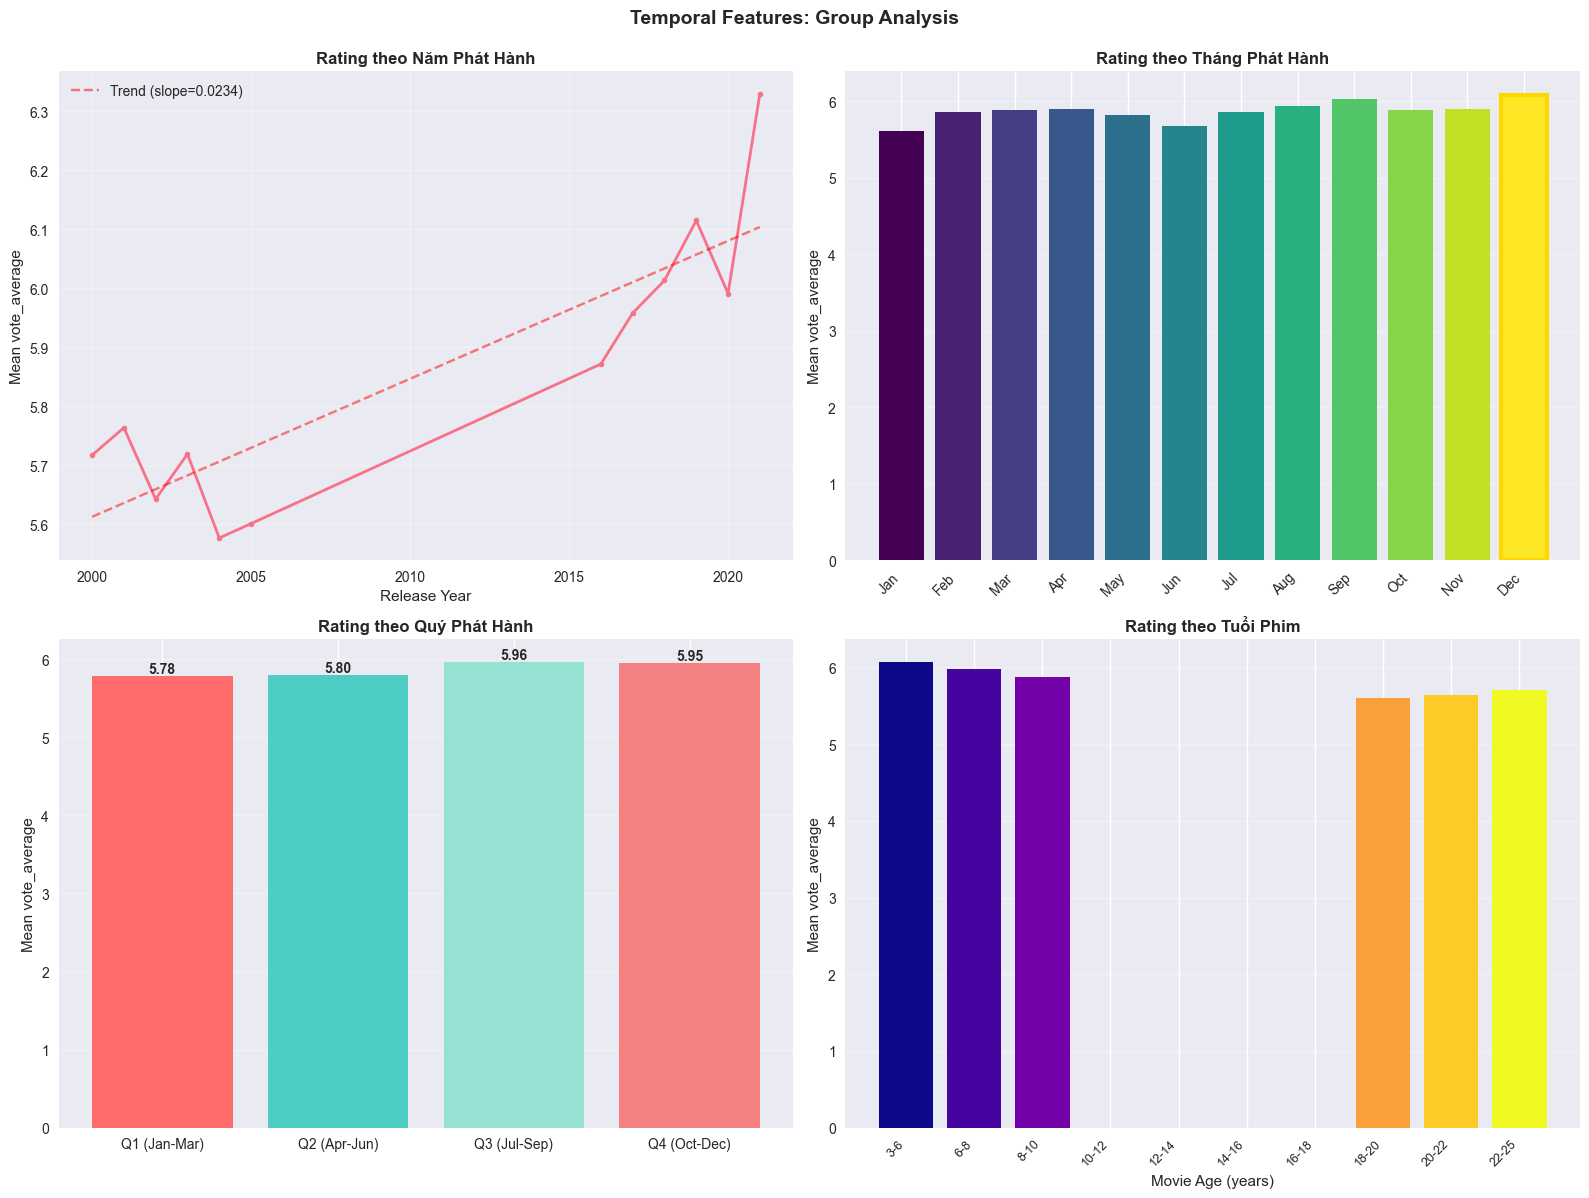


THỐNG KÊ THEO TEMPORAL FEATURES:

Rating theo Năm (top 5 năm tốt nhất):
                  mean  count
release_year                 
2021          6.329377     69
2019          6.114643   1055
2018          6.012999   1092
2020          5.990839    862
2017          5.957643   1079

Rating theo Tháng:
                   mean  count
release_month                 
1              5.616204    724
2              5.865328    594
3              5.884650    657
4              5.906119    563
5              5.819811    544
6              5.677485    573
7              5.861255    501
8              5.934901    618
9              6.034114    858
10             5.891030    982
11             5.894866    737
12             6.086997    649

Rating theo Quý:
                     mean  count
release_quarter                 
1                5.780431   1975
2                5.800191   1680
3                5.959296   1977
4                5.945932   2368


In [89]:
# Group Analysis theo Temporal Features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 1. Rating theo năm
if 'release_year' in df_train_all.columns:
    ax = axes[0]
    year_rating = df_train_all.groupby('release_year')[target_col].agg(['mean', 'count'])
    year_rating = year_rating[year_rating['count'] >= 10]  # Chỉ lấy năm có >= 10 phim
    
    ax.plot(year_rating.index, year_rating['mean'], marker='o', linewidth=2, markersize=4)
    ax.set_xlabel('Release Year', fontsize=11)
    ax.set_ylabel(f'Mean {target_col}', fontsize=11)
    ax.set_title('Rating theo Năm Phát Hành', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Trend line
    z = np.polyfit(year_rating.index, year_rating['mean'], 1)
    p = np.poly1d(z)
    ax.plot(year_rating.index, p(year_rating.index), "r--", alpha=0.5, label=f'Trend (slope={z[0]:.4f})')
    ax.legend()

# 2. Rating theo tháng
if 'release_month' in df_train_all.columns:
    ax = axes[1]
    month_rating = df_train_all.groupby('release_month')[target_col].mean().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    bars = ax.bar(range(1, 13), month_rating.values, color=plt.cm.viridis(np.linspace(0, 1, 12)))
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, rotation=45, ha='right')
    ax.set_ylabel(f'Mean {target_col}', fontsize=11)
    ax.set_title('Rating theo Tháng Phát Hành', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight best month
    best_month = month_rating.idxmax()
    bars[best_month - 1].set_edgecolor('gold')
    bars[best_month - 1].set_linewidth(3)

# 3. Rating theo quý
if 'release_quarter' in df_train_all.columns:
    ax = axes[2]
    quarter_rating = df_train_all.groupby('release_quarter')[target_col].mean().sort_index()
    quarter_names = ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)']
    
    bars = ax.bar(range(1, 5), quarter_rating.values, 
                 color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181'])
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels(quarter_names)
    ax.set_ylabel(f'Mean {target_col}', fontsize=11)
    ax.set_title('Rating theo Quý Phát Hành', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for i, (q, val) in enumerate(quarter_rating.items()):
        ax.text(i+1, val, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# 4. Rating theo movie_age
if 'movie_age' in df_train_all.columns:
    ax = axes[3]
    # Group movie_age thành bins
    df_train_all['movie_age_bin'] = pd.cut(df_train_all['movie_age'], bins=10)
    age_rating = df_train_all.groupby('movie_age_bin')[target_col].mean()
    
    age_labels = [f'{int(interval.left)}-{int(interval.right)}' for interval in age_rating.index]
    bars = ax.bar(range(len(age_rating)), age_rating.values,
                 color=plt.cm.plasma(np.linspace(0, 1, len(age_rating))))
    ax.set_xticks(range(len(age_rating)))
    ax.set_xticklabels(age_labels, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(f'Mean {target_col}', fontsize=11)
    ax.set_xlabel('Movie Age (years)', fontsize=11)
    ax.set_title('Rating theo Tuổi Phim', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Temporal Features: Group Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# In thống kê
print("\n" + "="*90)
print("THỐNG KÊ THEO TEMPORAL FEATURES:")
print("="*90)

if 'release_year' in df_train_all.columns:
    print(f"\nRating theo Năm (top 5 năm tốt nhất):")
    year_stats = df_train_all.groupby('release_year')[target_col].agg(['mean', 'count'])
    year_stats = year_stats[year_stats['count'] >= 10].sort_values('mean', ascending=False)
    print(year_stats.head(5).to_string())

if 'release_month' in df_train_all.columns:
    print(f"\nRating theo Tháng:")
    month_stats = df_train_all.groupby('release_month')[target_col].agg(['mean', 'count'])
    print(month_stats.to_string())

if 'release_quarter' in df_train_all.columns:
    print(f"\nRating theo Quý:")
    quarter_stats = df_train_all.groupby('release_quarter')[target_col].agg(['mean', 'count'])
    print(quarter_stats.to_string())


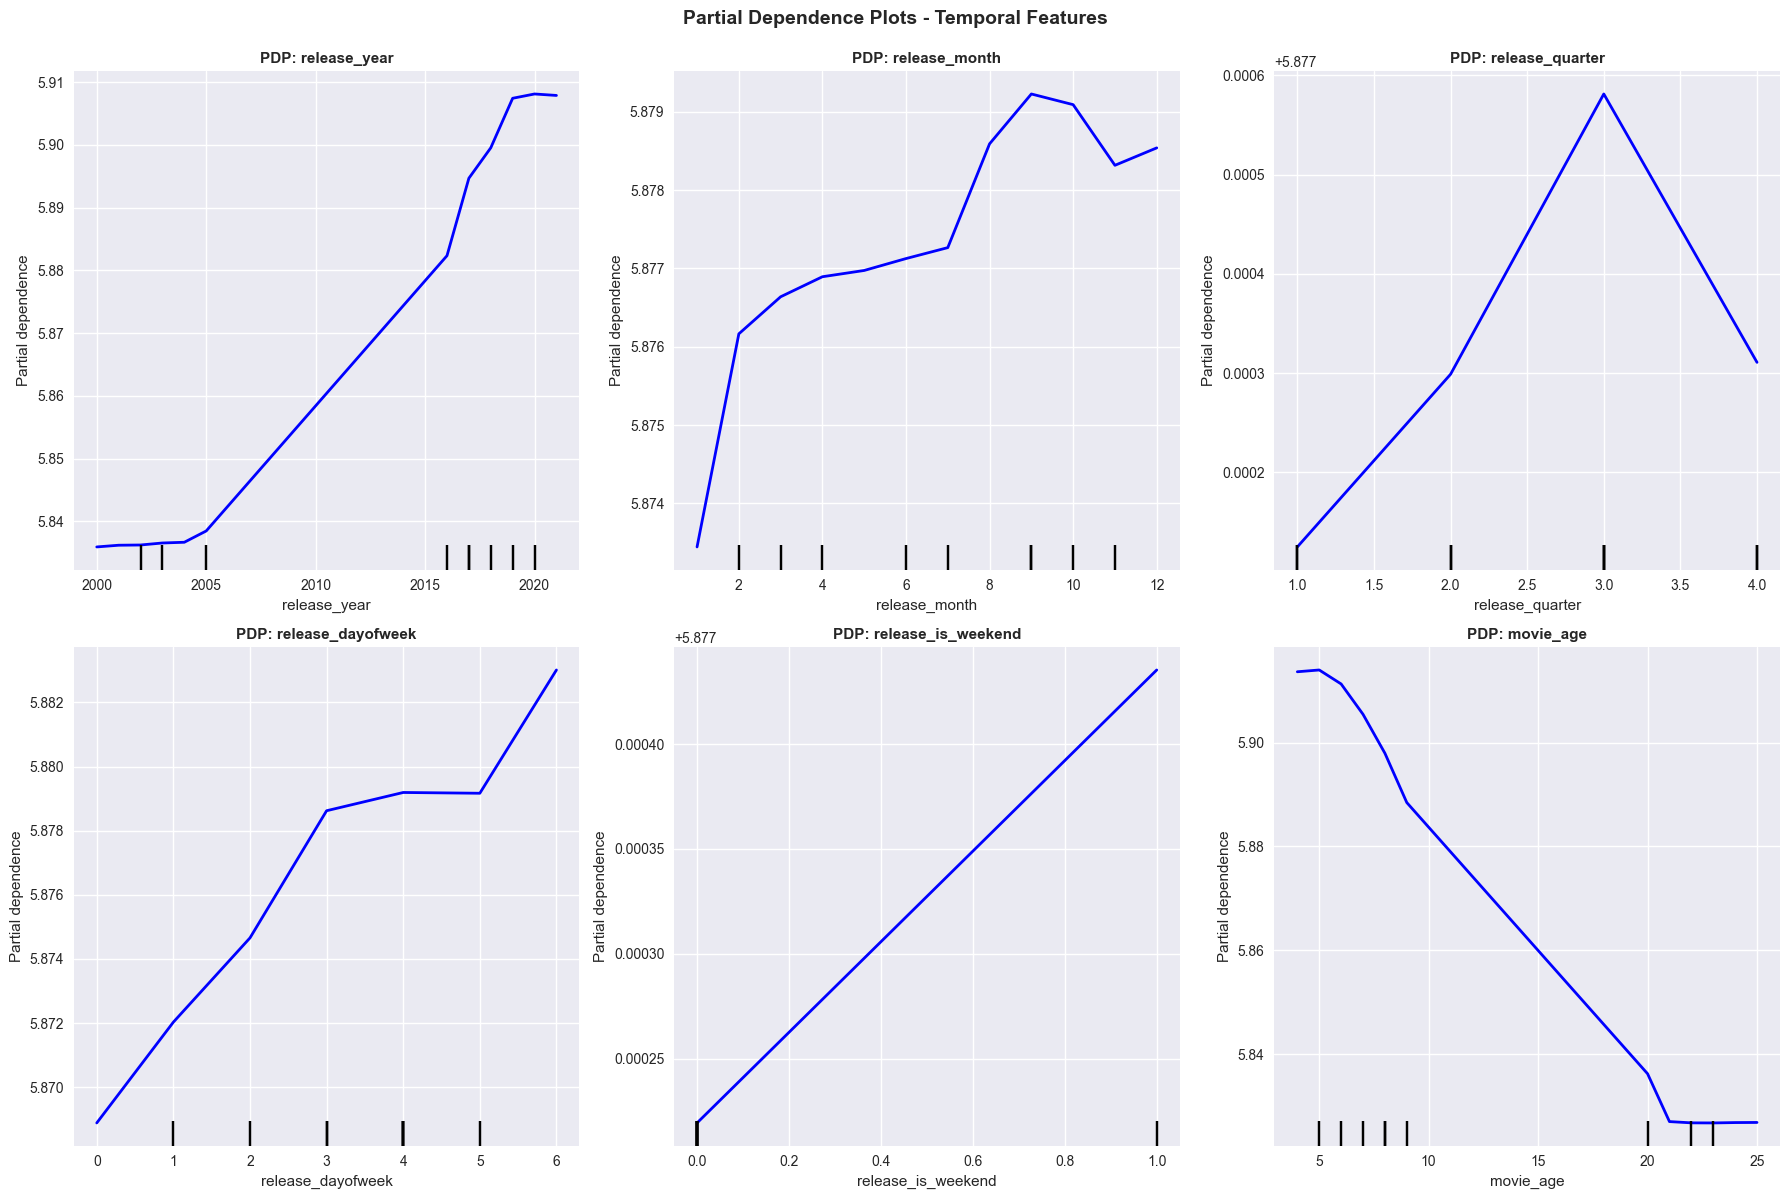

In [90]:
# Partial Dependence Plots cho Temporal Features
if len(available_temporal) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, feature in enumerate(available_temporal[:6]):  # Tối đa 6 features
        if feature in X_train_all.columns:
            ax = axes[idx]
            feature_idx = list(X_train_all.columns).index(feature)
            
            try:
                PartialDependenceDisplay.from_estimator(
                    rf_all, X_train_all, [feature_idx], ax=ax,
                    kind='average', grid_resolution=50,
                    line_kw={'linewidth': 2, 'color': 'blue'}
                )
                ax.set_title(f'PDP: {feature}', fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
            except:
                ax.text(0.5, 0.5, f'Cannot plot\n{feature}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'PDP: {feature} (Error)', fontsize=11)
    
    # Ẩn các axes không dùng
    for idx in range(len(available_temporal), 6):
        axes[idx].set_visible(False)
    
    plt.suptitle('Partial Dependence Plots - Temporal Features', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("Không có temporal features để vẽ PDP")


### 1.3.4. Ablation Study: So sánh Model có/không có Temporal Features


In [91]:
# Ablation Study: So sánh model có/không có temporal features
print("=" * 90)
print("ABLATION STUDY: So sánh Model có/không có Temporal Features")
print("=" * 90)

# Model với temporal features (đã có trong rf_all)
# Model không có temporal features
X_train_no_temporal = X_train_all.drop(columns=available_temporal)
X_test_no_temporal = X_test_all.drop(columns=available_temporal)

rf_no_temporal = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_no_temporal.fit(X_train_no_temporal, y_train_all)
y_pred_no_temporal = rf_no_temporal.predict(X_test_no_temporal)

r2_no_temporal = r2_score(y_test_all, y_pred_no_temporal)
rmse_no_temporal = np.sqrt(mean_squared_error(y_test_all, y_pred_no_temporal))
cv_scores_no_temporal = cross_val_score(rf_no_temporal, X_train_no_temporal, y_train_all, cv=5, scoring='r2')

print(f"\n1. Model VỚI Temporal Features:")
print(f"   Test R²: {r2_with_text:.4f}")
print(f"   Test RMSE: {rmse_with_text:.4f}")
print(f"   CV R² Mean: {cv_scores_with_text.mean():.4f} (+/- {cv_scores_with_text.std()*2:.4f})")

print(f"\n2. Model KHÔNG có Temporal Features:")
print(f"   Test R²: {r2_no_temporal:.4f}")
print(f"   Test RMSE: {rmse_no_temporal:.4f}")
print(f"   CV R² Mean: {cv_scores_no_temporal.mean():.4f} (+/- {cv_scores_no_temporal.std()*2:.4f})")

# So sánh
r2_diff_temporal = r2_with_text - r2_no_temporal
rmse_diff_temporal = rmse_no_temporal - rmse_with_text
r2_improvement_temporal = (r2_diff_temporal / abs(r2_no_temporal)) * 100 if r2_no_temporal != 0 else float('inf')

print(f"\n{'='*90}")
print("SO SÁNH:")
print(f"{'='*90}")
print(f"  R² improvement: {r2_diff_temporal:+.4f} ({r2_improvement_temporal:+.2f}%)")
print(f"  RMSE improvement: {rmse_diff_temporal:+.4f}")

if r2_with_text > r2_no_temporal:
    print(f"\n  ✅ Temporal features CÓ ảnh hưởng tích cực đến model performance")
else:
    print(f"\n  ⚠️  Temporal features KHÔNG cải thiện model performance đáng kể")

# Statistical test
t_stat_temporal, p_value_temporal = ttest_rel(cv_scores_with_text, cv_scores_no_temporal)
print(f"\n  Statistical Test (Paired t-test):")
print(f"    p-value: {p_value_temporal:.6f}")
if p_value_temporal < 0.05:
    if cv_scores_with_text.mean() > cv_scores_no_temporal.mean():
        print(f"    ✅ Sự khác biệt có ý nghĩa thống kê (p < 0.05)")
    else:
        print(f"    ⚠️  Model không temporal tốt hơn (p < 0.05)")
else:
    print(f"    ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)")


ABLATION STUDY: So sánh Model có/không có Temporal Features

1. Model VỚI Temporal Features:
   Test R²: 0.2858
   Test RMSE: 1.2707
   CV R² Mean: 0.2821 (+/- 0.0147)

2. Model KHÔNG có Temporal Features:
   Test R²: 0.2800
   Test RMSE: 1.2758
   CV R² Mean: 0.2767 (+/- 0.0194)

SO SÁNH:
  R² improvement: +0.0058 (+2.06%)
  RMSE improvement: +0.0051

  ✅ Temporal features CÓ ảnh hưởng tích cực đến model performance

  Statistical Test (Paired t-test):
    p-value: 0.110735
    ⚠️  Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)


### 1.3.5. Kết luận Hypothesis 3


In [92]:
# Kết luận Hypothesis 3
print("=" * 90)
print("KẾT LUẬN VỀ HYPOTHESIS 3: Temporal Features ảnh hưởng đến Rating")
print("=" * 90)

print("\n1. FEATURE IMPORTANCE:")
print(f"   - Temporal features chiếm {temporal_percentage:.2f}% tổng importance")
print(f"   - Feature quan trọng nhất: {temporal_importance.iloc[0]['feature']} "
      f"({temporal_importance.iloc[0]['importance']:.4f})")

print("\n2. GROUP ANALYSIS:")
if 'release_year' in df_train_all.columns:
    year_range = df_train_all['release_year'].max() - df_train_all['release_year'].min()
    year_std = df_train_all.groupby('release_year')[target_col].mean().std()
    print(f"   - Rating thay đổi theo năm: std = {year_std:.4f}")
if 'release_month' in df_train_all.columns:
    month_std = df_train_all.groupby('release_month')[target_col].mean().std()
    print(f"   - Rating thay đổi theo tháng: std = {month_std:.4f}")

print("\n3. ABLATION STUDY:")
print(f"   - Model với temporal: R² = {r2_with_text:.4f}")
print(f"   - Model không temporal: R² = {r2_no_temporal:.4f}")
print(f"   - Improvement: {r2_diff_temporal:+.4f} ({r2_improvement_temporal:+.2f}%)")

print("\n4. KẾT LUẬN CUỐI CÙNG:")
if (temporal_percentage > 1 and r2_with_text > r2_no_temporal and p_value_temporal < 0.05):
    print("   ✅ HYPOTHESIS 3 ĐƯỢC XÁC NHẬN:")
    print("      - Temporal features có ảnh hưởng đến rating")
    print(f"      - Temporal features chiếm {temporal_percentage:.2f}% importance")
    print(f"      - Model với temporal tốt hơn {r2_improvement_temporal:.2f}% về R²")
    print("      - Sự khác biệt có ý nghĩa thống kê (p < 0.05)")
else:
    print("   ⚠️  HYPOTHESIS 3 CHƯA ĐƯỢC XÁC NHẬN HOÀN TOÀN")
    if temporal_percentage <= 1:
        print("      - Temporal features có importance thấp")
    if r2_with_text <= r2_no_temporal:
        print("      - Model không temporal không kém hơn")
    if p_value_temporal >= 0.05:
        print("      - Sự khác biệt không có ý nghĩa thống kê")


KẾT LUẬN VỀ HYPOTHESIS 3: Temporal Features ảnh hưởng đến Rating

1. FEATURE IMPORTANCE:
   - Temporal features chiếm 1.62% tổng importance
   - Feature quan trọng nhất: movie_age (0.0064)

2. GROUP ANALYSIS:
   - Rating thay đổi theo năm: std = 0.2295
   - Rating thay đổi theo tháng: std = 0.1296

3. ABLATION STUDY:
   - Model với temporal: R² = 0.2858
   - Model không temporal: R² = 0.2800
   - Improvement: +0.0058 (+2.06%)

4. KẾT LUẬN CUỐI CÙNG:
   ⚠️  HYPOTHESIS 3 CHƯA ĐƯỢC XÁC NHẬN HOÀN TOÀN
      - Sự khác biệt không có ý nghĩa thống kê


## 1.4. Hypothesis 4: Categorical Features có thể giảm chiều

**Giả thuyết**: Các biến phân loại (genres, languages, countries, certification, etc.) thật sự ảnh hưởng mạnh đến việc dự đoán rating và có thể giảm chiều mà không làm mất thông tin quan trọng.


### 1.4.1. Phân loại và đếm Categorical Features

Xác định tất cả categorical features và phân loại chúng.


In [93]:
# Phân tích Categorical Features
print("=" * 90)
print("PHÂN TÍCH CATEGORICAL FEATURES")
print("=" * 90)

# Xác định categorical features
categorical_patterns = {
    'genre': [col for col in df_train_all.columns if col.startswith('genre_')],
    'language': [col for col in df_train_all.columns if col.startswith('language_')],
    'country': [col for col in df_train_all.columns if col.startswith('country_')],
    'certification': [col for col in df_train_all.columns if 'certification' in col.lower()],
    'director': [col for col in df_train_all.columns if 'director' in col.lower()],
    'company': [col for col in df_train_all.columns if 'company' in col.lower()],
    'other_categorical': [col for col in df_train_all.columns 
                         if col in ['has_cast', 'num_cast', 'num_genres', 'release_is_weekend']]
}

# Tổng hợp tất cả categorical features
all_categorical = []
for category, features in categorical_patterns.items():
    all_categorical.extend(features)
    print(f"\n{category.upper()}: {len(features)} features")
    if len(features) > 0:
        print(f"  Examples: {features[:3]}")

print(f"\n{'='*90}")
print(f"TỔNG SỐ CATEGORICAL FEATURES: {len(all_categorical)}")
print(f"{'='*90}")

# Lấy importance của categorical features
categorical_importance = feature_importance[feature_importance['feature'].isin(all_categorical)].copy()
categorical_importance['category'] = categorical_importance['feature'].apply(
    lambda x: next((cat for cat, feats in categorical_patterns.items() if x in feats), 'other')
)
categorical_importance = categorical_importance.sort_values('importance', ascending=False)

# Tổng hợp theo category
category_summary = categorical_importance.groupby('category').agg({
    'importance': ['sum', 'mean', 'count']
}).round(4)
category_summary.columns = ['Total Importance', 'Mean Importance', 'Count']

print(f"\nTỔNG HỢP IMPORTANCE THEO CATEGORY:")
print("="*90)
print(category_summary.to_string())

# Tính tổng importance
total_categorical_importance = categorical_importance['importance'].sum()
categorical_percentage = (total_categorical_importance / total_all_importance) * 100

print(f"\n  - Tổng importance của categorical features: {total_categorical_importance:.4f}")
print(f"  - Categorical features chiếm: {categorical_percentage:.2f}% tổng importance")


PHÂN TÍCH CATEGORICAL FEATURES

GENRE: 20 features
  Examples: ['genre_action', 'genre_adventure', 'genre_animation']

LANGUAGE: 16 features
  Examples: ['language_de', 'language_en', 'language_es']

COUNTRY: 20 features
  Examples: ['country_au', 'country_be', 'country_ca']

CERTIFICATION: 1 features
  Examples: ['certification_US_encoded']

DIRECTOR: 2 features
  Examples: ['director_count_encoded', 'director_target_encoded']

COMPANY: 1 features
  Examples: ['company_target_encoded']

OTHER_CATEGORICAL: 4 features
  Examples: ['has_cast', 'num_cast', 'num_genres']

TỔNG SỐ CATEGORICAL FEATURES: 64

TỔNG HỢP IMPORTANCE THEO CATEGORY:
                   Total Importance  Mean Importance  Count
category                                                   
certification                0.0032           0.0032      1
company                      0.0017           0.0017      1
country                      0.0029           0.0001     20
director                     0.0017           0.0008    

### 1.4.2. Visualization: Categorical Features Importance

Bar charts hiển thị importance của categorical features.


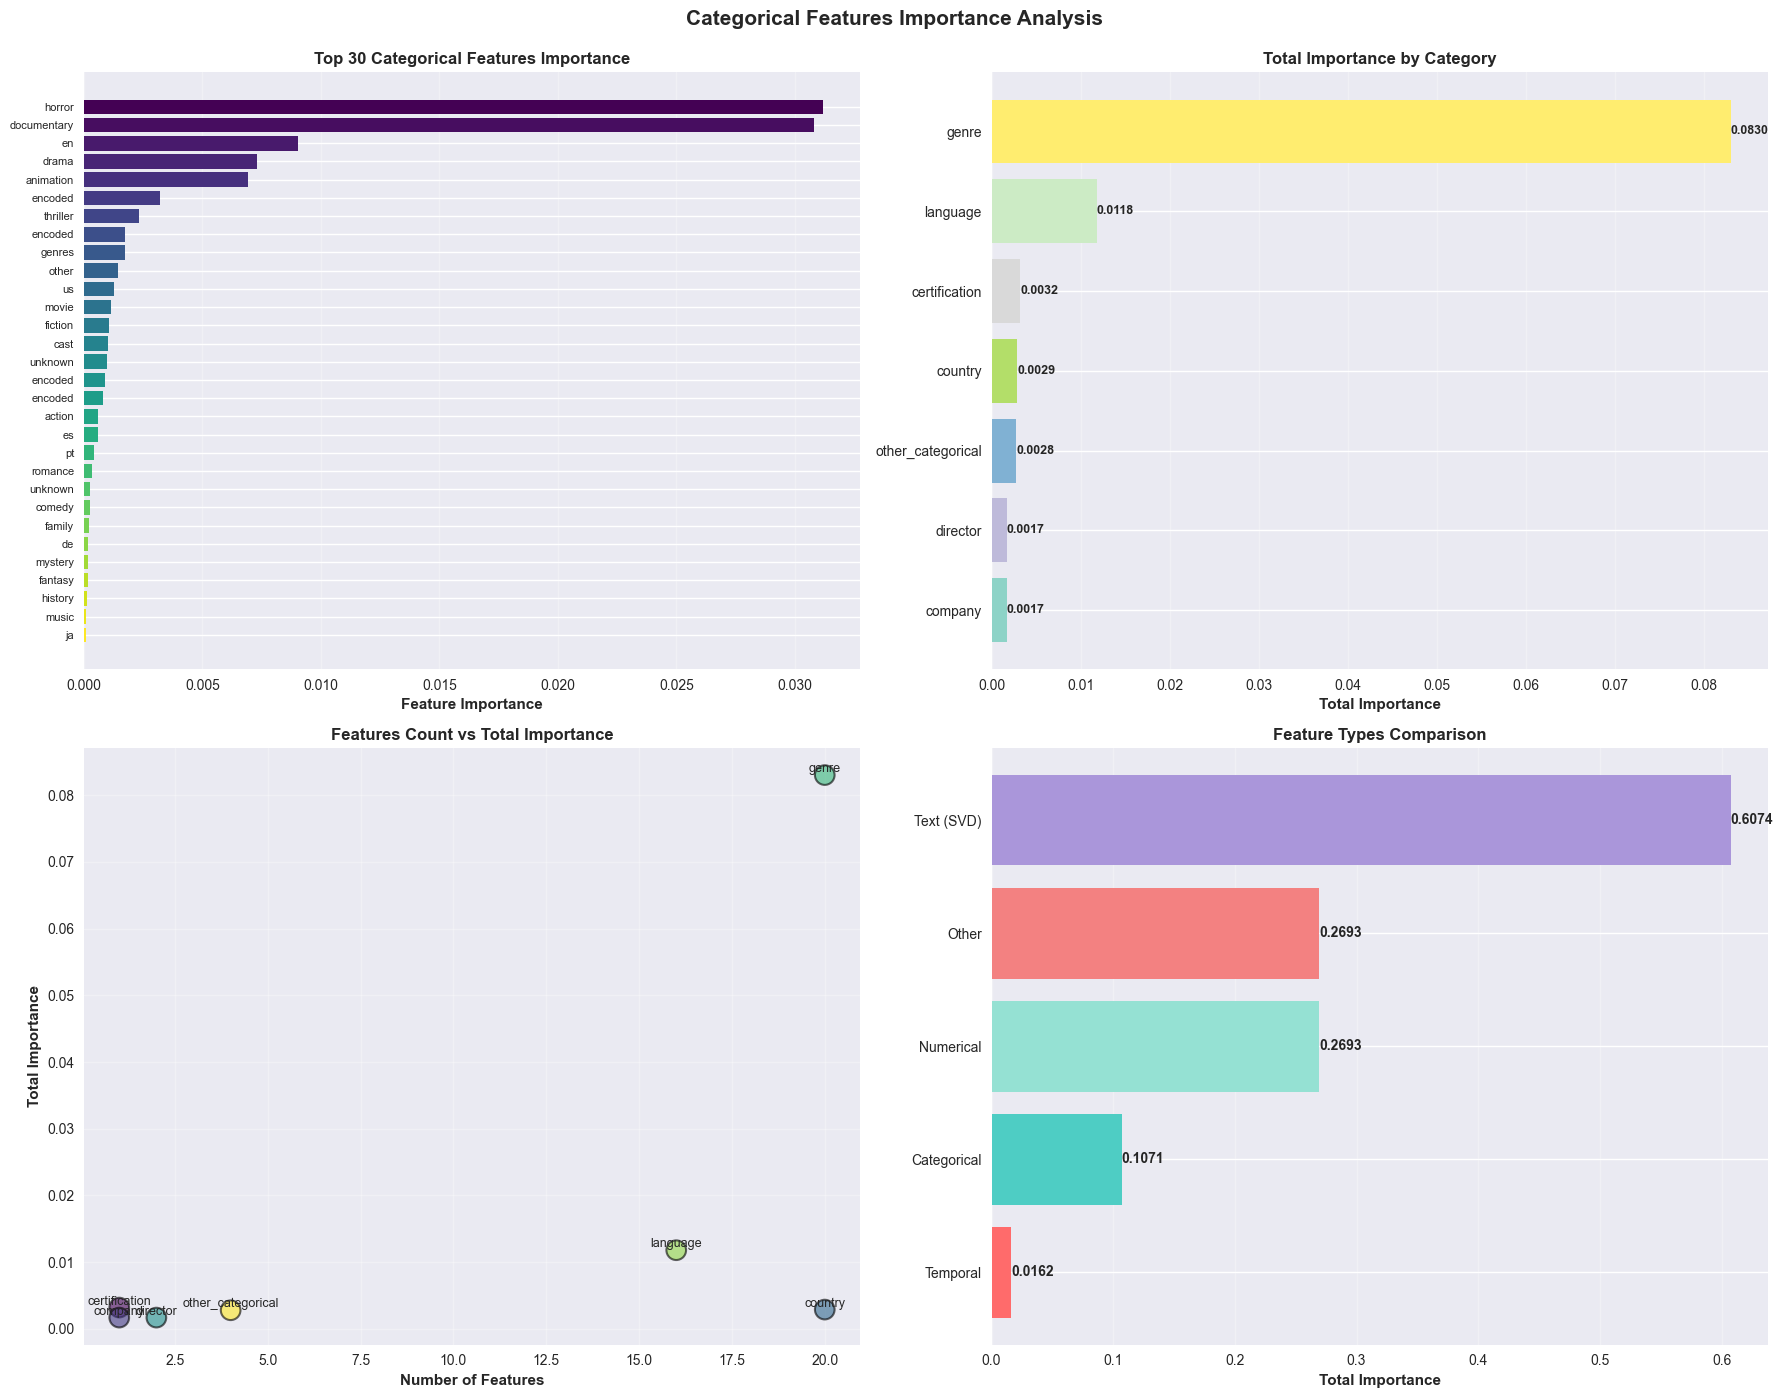

In [94]:
# Visualization: Categorical Features Importance
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Top 30 Categorical Features
ax1 = axes[0, 0]
top_30_cat = categorical_importance.head(30)
bars1 = ax1.barh(range(len(top_30_cat)), top_30_cat['importance'],
                color=plt.cm.viridis(np.linspace(0, 1, len(top_30_cat))))
ax1.set_yticks(range(len(top_30_cat)))
ax1.set_yticklabels([f.split('_')[-1] if len(f.split('_')) > 1 else f[:20] 
                     for f in top_30_cat['feature']], fontsize=8)
ax1.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax1.set_title('Top 30 Categorical Features Importance', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Tổng hợp theo Category
ax2 = axes[0, 1]
category_totals = category_summary['Total Importance'].sort_values(ascending=True)
bars2 = ax2.barh(range(len(category_totals)), category_totals.values,
                color=plt.cm.Set3(np.linspace(0, 1, len(category_totals))))
ax2.set_yticks(range(len(category_totals)))
ax2.set_yticklabels(category_totals.index, fontsize=10)
ax2.set_xlabel('Total Importance', fontsize=11, fontweight='bold')
ax2.set_title('Total Importance by Category', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for i, (cat, val) in enumerate(category_totals.items()):
    ax2.text(val, i, f'{val:.4f}', va='center', ha='left', fontweight='bold', fontsize=9)

# 3. Số lượng features vs Total Importance
ax3 = axes[1, 0]
category_counts = category_summary['Count']
category_importance_sum = category_summary['Total Importance']
scatter = ax3.scatter(category_counts, category_importance_sum, 
                     s=200, alpha=0.6, c=range(len(category_counts)), 
                     cmap='viridis', edgecolors='black', linewidth=1.5)

for idx, (cat, row) in enumerate(category_summary.iterrows()):
    ax3.annotate(cat, (row['Count'], row['Total Importance']),
                fontsize=9, ha='center', va='bottom')

ax3.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax3.set_ylabel('Total Importance', fontsize=11, fontweight='bold')
ax3.set_title('Features Count vs Total Importance', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. So sánh với các loại features khác
ax4 = axes[1, 1]
feature_types = pd.DataFrame({
    'Type': ['Categorical', 'Text (SVD)', 'Temporal', 'Numerical', 'Other'],
    'Total Importance': [
        total_categorical_importance,
        total_text_importance,
        total_temporal_importance,
        feature_importance[~feature_importance['feature'].isin(
            all_categorical + text_features + available_temporal
        )]['importance'].sum(),
        0  # Other sẽ được tính sau
    ]
})
# Tính Other
other_features = [f for f in feature_importance['feature'] 
                 if f not in all_categorical + text_features + available_temporal]
feature_types.loc[4, 'Total Importance'] = feature_importance[
    feature_importance['feature'].isin(other_features)
]['importance'].sum()

feature_types = feature_types.sort_values('Total Importance', ascending=True)
bars4 = ax4.barh(range(len(feature_types)), feature_types['Total Importance'].values,
                 color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA'])
ax4.set_yticks(range(len(feature_types)))
ax4.set_yticklabels(feature_types['Type'], fontsize=10)
ax4.set_xlabel('Total Importance', fontsize=11, fontweight='bold')
ax4.set_title('Feature Types Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

for i, val in enumerate(feature_types['Total Importance']):
    ax4.text(val, i, f'{val:.4f}', va='center', ha='left', fontweight='bold', fontsize=10)

plt.suptitle('Categorical Features Importance Analysis', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### 1.4.3. Feature Selection: Giảm chiều Categorical Features

Sử dụng Variance Threshold và Feature Importance để chọn top categorical features.


In [95]:
# Feature Selection: Giảm chiều Categorical Features
print("=" * 90)
print("FEATURE SELECTION: Giảm chiều Categorical Features")
print("=" * 90)

from sklearn.feature_selection import VarianceThreshold

# Bước 1: Variance Threshold - Loại bỏ features có variance thấp
print("\n1. VARIANCE THRESHOLD:")
print("-" * 90)

X_categorical = X_train_all[all_categorical].copy()
variance_threshold = VarianceThreshold(threshold=0.01)
X_categorical_var = variance_threshold.fit_transform(X_categorical)
selected_by_variance = X_categorical.columns[variance_threshold.get_support()].tolist()

print(f"  - Số categorical features ban đầu: {len(all_categorical)}")
print(f"  - Sau Variance Threshold (threshold=0.01): {len(selected_by_variance)}")
print(f"  - Đã loại bỏ: {len(all_categorical) - len(selected_by_variance)} features")

# Bước 2: Chọn top features theo importance
print("\n2. TOP FEATURES BY IMPORTANCE:")
print("-" * 90)

# Chọn top N features từ mỗi category
top_n_per_category = 10
selected_by_importance = []

for category, features in categorical_patterns.items():
    cat_features = categorical_importance[
        categorical_importance['feature'].isin(features)
    ].head(top_n_per_category)['feature'].tolist()
    selected_by_importance.extend(cat_features)
    print(f"  - {category}: Chọn top {len(cat_features)} features")

print(f"\n  - Tổng số features được chọn: {len(selected_by_importance)}")

# Bước 3: Kết hợp cả 2 phương pháp
selected_categorical = list(set(selected_by_variance) & set(selected_by_importance))
if len(selected_categorical) == 0:
    selected_categorical = list(set(selected_by_variance) | set(selected_by_importance))

print(f"\n3. KẾT HỢP:")
print("-" * 90)
print(f"  - Features được chọn (giao của 2 phương pháp): {len(selected_categorical)}")
print(f"  - Giảm từ {len(all_categorical)} xuống {len(selected_categorical)}")
print(f"  - Tỷ lệ giữ lại: {len(selected_categorical)/len(all_categorical)*100:.2f}%")

# Tính importance của selected features
selected_importance = categorical_importance[
    categorical_importance['feature'].isin(selected_categorical)
]['importance'].sum()
selected_percentage = (selected_importance / total_categorical_importance) * 100

print(f"\n  - Importance của selected features: {selected_importance:.4f}")
print(f"  - Giữ lại {selected_percentage:.2f}% importance của tất cả categorical features")


FEATURE SELECTION: Giảm chiều Categorical Features

1. VARIANCE THRESHOLD:
------------------------------------------------------------------------------------------
  - Số categorical features ban đầu: 64
  - Sau Variance Threshold (threshold=0.01): 58
  - Đã loại bỏ: 6 features

2. TOP FEATURES BY IMPORTANCE:
------------------------------------------------------------------------------------------
  - genre: Chọn top 10 features
  - language: Chọn top 10 features
  - country: Chọn top 10 features
  - certification: Chọn top 1 features
  - director: Chọn top 2 features
  - company: Chọn top 1 features
  - other_categorical: Chọn top 4 features

  - Tổng số features được chọn: 38

3. KẾT HỢP:
------------------------------------------------------------------------------------------
  - Features được chọn (giao của 2 phương pháp): 35
  - Giảm từ 64 xuống 35
  - Tỷ lệ giữ lại: 54.69%

  - Importance của selected features: 0.1058
  - Giữ lại 98.77% importance của tất cả categorical featu

### 1.4.4. So sánh Model: Tất cả vs Selected Categorical Features

Kiểm tra xem có thể giảm chiều mà không làm mất thông tin quan trọng.


In [96]:
# So sánh Model: Tất cả vs Selected Categorical Features
print("=" * 90)
print("SO SÁNH MODEL: Tất cả vs Selected Categorical Features")
print("=" * 90)

# Model 1: Với tất cả categorical features (đã có trong rf_all)
print(f"\n1. Model VỚI TẤT CẢ Categorical Features ({len(all_categorical)} features):")
print(f"   Test R²: {r2_with_text:.4f}")
print(f"   Test RMSE: {rmse_with_text:.4f}")
print(f"   CV R² Mean: {cv_scores_with_text.mean():.4f} (+/- {cv_scores_with_text.std()*2:.4f})")

# Model 2: Chỉ với selected categorical features
# Loại bỏ các categorical features không được chọn
features_to_remove = [f for f in all_categorical if f not in selected_categorical]
X_train_selected = X_train_all.drop(columns=features_to_remove)
X_test_selected = X_test_all.drop(columns=features_to_remove)

rf_selected = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_selected.fit(X_train_selected, y_train_all)
y_pred_selected = rf_selected.predict(X_test_selected)

r2_selected = r2_score(y_test_all, y_pred_selected)
rmse_selected = np.sqrt(mean_squared_error(y_test_all, y_pred_selected))
cv_scores_selected = cross_val_score(rf_selected, X_train_selected, y_train_all, cv=5, scoring='r2')

print(f"\n2. Model VỚI SELECTED Categorical Features ({len(selected_categorical)} features):")
print(f"   Test R²: {r2_selected:.4f}")
print(f"   Test RMSE: {rmse_selected:.4f}")
print(f"   CV R² Mean: {cv_scores_selected.mean():.4f} (+/- {cv_scores_selected.std()*2:.4f})")

# So sánh
r2_diff_cat = r2_with_text - r2_selected
rmse_diff_cat = rmse_selected - rmse_with_text
r2_loss = (r2_diff_cat / abs(r2_with_text)) * 100 if r2_with_text != 0 else 0

print(f"\n{'='*90}")
print("SO SÁNH:")
print(f"{'='*90}")
print(f"  R² difference: {r2_diff_cat:+.4f} ({r2_loss:+.2f}%)")
print(f"  RMSE difference: {rmse_diff_cat:+.4f}")
print(f"  Số features giảm: {len(all_categorical) - len(selected_categorical)} ({len(all_categorical)} → {len(selected_categorical)})")
print(f"  Importance giữ lại: {selected_percentage:.2f}%")

if abs(r2_diff_cat) < 0.01:  # Chênh lệch < 1%
    print(f"\n  ✅ CÓ THỂ GIẢM CHIỀU: Performance gần như không đổi")
    print(f"     - Giảm {len(all_categorical) - len(selected_categorical)} features")
    print(f"     - R² chỉ giảm {abs(r2_loss):.2f}%")
    print(f"     - Giữ lại {selected_percentage:.2f}% importance")
elif abs(r2_diff_cat) < 0.05:  # Chênh lệch < 5%
    print(f"\n  ⚠️  CÓ THỂ GIẢM CHIỀU với trade-off nhỏ")
    print(f"     - Performance giảm {abs(r2_loss):.2f}%")
    print(f"     - Cần cân nhắc giữa số features và performance")
else:
    print(f"\n  ❌ KHÔNG NÊN GIẢM CHIỀU: Performance giảm đáng kể ({abs(r2_loss):.2f}%)")

# Statistical test
t_stat_cat, p_value_cat = ttest_rel(cv_scores_with_text, cv_scores_selected)
print(f"\n  Statistical Test (Paired t-test):")
print(f"    p-value: {p_value_cat:.6f}")
if p_value_cat >= 0.05:
    print(f"    ✅ Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)")
    print(f"       → Có thể giảm chiều mà không mất thông tin quan trọng")
else:
    print(f"    ⚠️  Có sự khác biệt có ý nghĩa thống kê (p < 0.05)")
    if cv_scores_with_text.mean() > cv_scores_selected.mean():
        print(f"       → Model với tất cả features tốt hơn")
    else:
        print(f"       → Model với selected features tốt hơn")


SO SÁNH MODEL: Tất cả vs Selected Categorical Features

1. Model VỚI TẤT CẢ Categorical Features (64 features):
   Test R²: 0.2858
   Test RMSE: 1.2707
   CV R² Mean: 0.2821 (+/- 0.0147)

2. Model VỚI SELECTED Categorical Features (35 features):
   Test R²: 0.2862
   Test RMSE: 1.2703
   CV R² Mean: 0.2806 (+/- 0.0175)

SO SÁNH:
  R² difference: -0.0004 (-0.14%)
  RMSE difference: -0.0004
  Số features giảm: 29 (64 → 35)
  Importance giữ lại: 98.77%

  ✅ CÓ THỂ GIẢM CHIỀU: Performance gần như không đổi
     - Giảm 29 features
     - R² chỉ giảm 0.14%
     - Giữ lại 98.77% importance

  Statistical Test (Paired t-test):
    p-value: 0.332248
    ✅ Không có sự khác biệt có ý nghĩa thống kê (p >= 0.05)
       → Có thể giảm chiều mà không mất thông tin quan trọng


### 1.4.5. Visualization: So sánh Performance

Bar chart so sánh performance của model với tất cả vs selected categorical features.


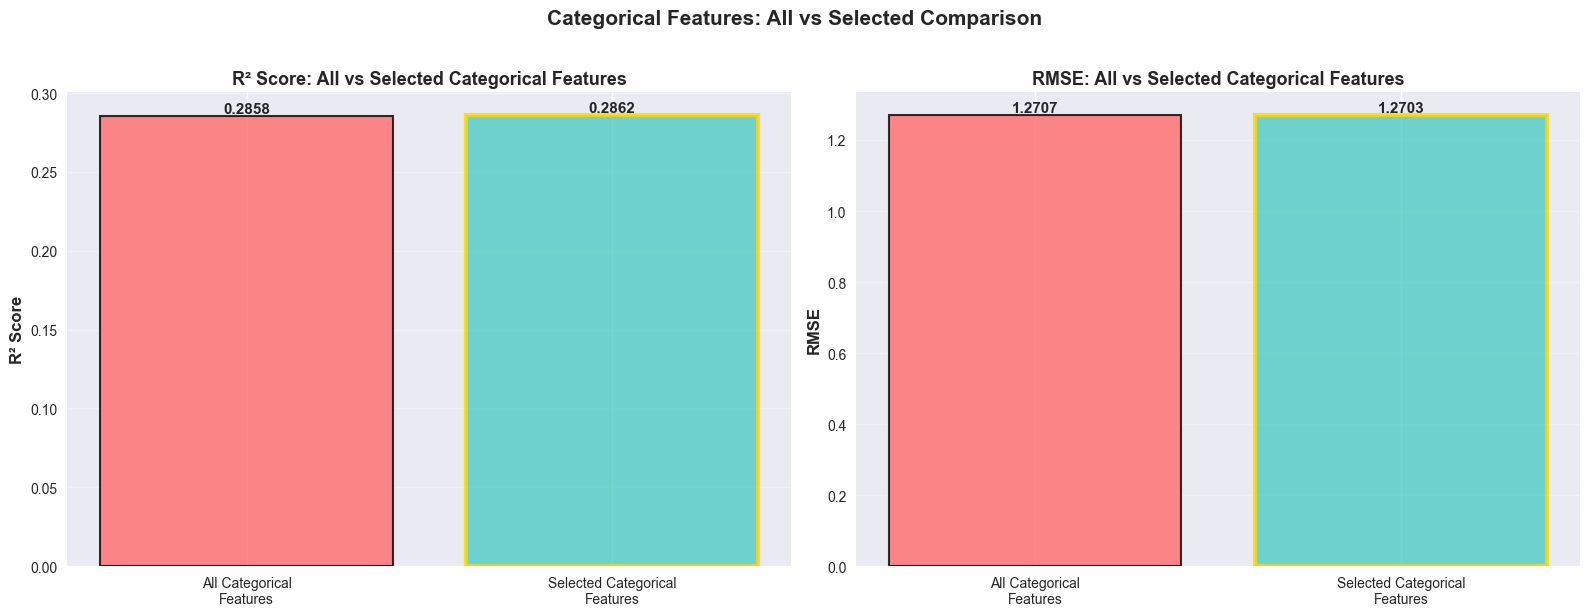


BẢNG TỔNG KẾT:
                        Model  Num Features  Test R²  Test RMSE  CV R² Mean  Importance
     All Categorical Features            64 0.285786   1.270680    0.282071    0.107127
Selected Categorical Features            35 0.286186   1.270323    0.280626    0.105814


In [97]:
# Visualization: So sánh Performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
models_cat = ['All Categorical\nFeatures', 'Selected Categorical\nFeatures']
r2_scores_cat = [r2_with_text, r2_selected]
rmse_scores_cat = [rmse_with_text, rmse_selected]

bars1 = ax1.bar(models_cat, r2_scores_cat, color=['#FF6B6B', '#4ECDC4'], 
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score: All vs Selected Categorical Features', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars1, r2_scores_cat):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Highlight best
if r2_with_text > r2_selected:
    bars1[0].set_edgecolor('gold')
    bars1[0].set_linewidth(3)
else:
    bars1[1].set_edgecolor('gold')
    bars1[1].set_linewidth(3)

# RMSE comparison
bars2 = ax2.bar(models_cat, rmse_scores_cat, color=['#FF6B6B', '#4ECDC4'],
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('RMSE: All vs Selected Categorical Features', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars2, rmse_scores_cat):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Highlight best (lowest RMSE)
if rmse_with_text < rmse_selected:
    bars2[0].set_edgecolor('gold')
    bars2[0].set_linewidth(3)
else:
    bars2[1].set_edgecolor('gold')
    bars2[1].set_linewidth(3)

plt.suptitle('Categorical Features: All vs Selected Comparison', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*90)
print("BẢNG TỔNG KẾT:")
print("="*90)
summary_cat_df = pd.DataFrame({
    'Model': ['All Categorical Features', 'Selected Categorical Features'],
    'Num Features': [len(all_categorical), len(selected_categorical)],
    'Test R²': r2_scores_cat,
    'Test RMSE': rmse_scores_cat,
    'CV R² Mean': [cv_scores_with_text.mean(), cv_scores_selected.mean()],
    'Importance': [total_categorical_importance, selected_importance]
})
print(summary_cat_df.to_string(index=False))


### 1.4.6. Kết luận Hypothesis 4


In [98]:
# Kết luận Hypothesis 4
print("=" * 90)
print("KẾT LUẬN VỀ HYPOTHESIS 4: Categorical Features có thể giảm chiều")
print("=" * 90)

print("\n1. FEATURE IMPORTANCE:")
print(f"   - Categorical features chiếm {categorical_percentage:.2f}% tổng importance")
print(f"   - Category quan trọng nhất: {category_summary['Total Importance'].idxmax()} "
      f"({category_summary['Total Importance'].max():.4f})")

print("\n2. FEATURE SELECTION:")
print(f"   - Số features ban đầu: {len(all_categorical)}")
print(f"   - Số features sau selection: {len(selected_categorical)}")
print(f"   - Giảm: {len(all_categorical) - len(selected_categorical)} features "
      f"({(1 - len(selected_categorical)/len(all_categorical))*100:.2f}%)")
print(f"   - Importance giữ lại: {selected_percentage:.2f}%")

print("\n3. MODEL COMPARISON:")
print(f"   - Model với tất cả: R² = {r2_with_text:.4f}")
print(f"   - Model với selected: R² = {r2_selected:.4f}")
print(f"   - Chênh lệch: {r2_diff_cat:+.4f} ({r2_loss:+.2f}%)")

print("\n4. KẾT LUẬN CUỐI CÙNG:")
if (categorical_percentage > 5 and 
    abs(r2_diff_cat) < 0.01 and 
    selected_percentage > 80 and
    p_value_cat >= 0.05):
    print("   ✅ HYPOTHESIS 4 ĐƯỢC XÁC NHẬN:")
    print("      - Categorical features ảnh hưởng mạnh đến rating")
    print(f"      - Có thể giảm chiều từ {len(all_categorical)} xuống {len(selected_categorical)} features")
    print(f"      - Performance gần như không đổi (chênh lệch {abs(r2_loss):.2f}%)")
    print(f"      - Giữ lại {selected_percentage:.2f}% importance")
    print("      - Không mất thông tin quan trọng (p >= 0.05)")
elif (categorical_percentage > 5 and abs(r2_diff_cat) < 0.05):
    print("   ⚠️  HYPOTHESIS 4 ĐƯỢC XÁC NHẬN MỘT PHẦN:")
    print("      - Có thể giảm chiều với trade-off nhỏ")
    print(f"      - Performance giảm {abs(r2_loss):.2f}%")
    print("      - Cần cân nhắc giữa số features và performance")
else:
    print("   ❌ HYPOTHESIS 4 CHƯA ĐƯỢC XÁC NHẬN")
    if categorical_percentage <= 5:
        print("      - Categorical features có importance thấp")
    if abs(r2_diff_cat) >= 0.05:
        print(f"      - Performance giảm đáng kể ({abs(r2_loss):.2f}%) khi giảm chiều")
    if selected_percentage <= 80:
        print(f"      - Chỉ giữ lại {selected_percentage:.2f}% importance")


KẾT LUẬN VỀ HYPOTHESIS 4: Categorical Features có thể giảm chiều

1. FEATURE IMPORTANCE:
   - Categorical features chiếm 10.71% tổng importance
   - Category quan trọng nhất: genre (0.0830)

2. FEATURE SELECTION:
   - Số features ban đầu: 64
   - Số features sau selection: 35
   - Giảm: 29 features (45.31%)
   - Importance giữ lại: 98.77%

3. MODEL COMPARISON:
   - Model với tất cả: R² = 0.2858
   - Model với selected: R² = 0.2862
   - Chênh lệch: -0.0004 (-0.14%)

4. KẾT LUẬN CUỐI CÙNG:
   ✅ HYPOTHESIS 4 ĐƯỢC XÁC NHẬN:
      - Categorical features ảnh hưởng mạnh đến rating
      - Có thể giảm chiều từ 64 xuống 35 features
      - Performance gần như không đổi (chênh lệch 0.14%)
      - Giữ lại 98.77% importance
      - Không mất thông tin quan trọng (p >= 0.05)
